In [13]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(plt, name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

%load_ext version_information
%version_information pandas, numpy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.15.4
Wed Mar 20 21:48:34 2019 PDT

## Bayesian Modeling Discussion

We can model the probability of an outcome $y$ as $P_t(y)$ using a **Gamma distribution** where time $t$ is defined below.

The PMF is given by

$$
$$

where $t$ is the time metric and $\alpha$ & $\beta$ are solved for with MCMC.

Based on a set of goalie pull observations $X$ from 2003-2007 NHL games, we'll solve for the posterior distribution $P_t(y|X)$, the probability of the outcome $y$, given the observations. This is done computationally using markov chain monte carlo and the `pymc3` library.

The outcomes we're interested in are $y = \big\{\mathrm{goal\;for}, \mathrm{goal\;against}, \mathrm{no\;goal}\big\}$. 

We'll use a **uniform prior** over the domain of times (last 5mins). Note: when gathering the observations, we throw out goalie pulls greater than 5 minutes from the end of the game (due to high likelihood of false positives when parsing goalie pulls from the raw game table).

Once we find the posteriors discussed above, we can study the risk reward of pulling a goalie. We'll compare posteriors to find the odds of scoring a goal (and the odds of getting scored on) over time $t$ where:
 - **t = Time elapsed** e.g. if there's 3 minutes left, what is the chance that pulling the goalie will result in a goal for?
 - **t = Time since goalie pull** e.g. after the goalie has been pulled for 1 minute, what is the chance of getting a goal?

In [2]:
import pymc3 as pm

### Load the training data

In [3]:
ls ../../data/processed/pkl/

20032004_goalie_pulls_2019-03-01.pkl  20062007_goalie_pulls_2019-03-01.pkl
20052006_goalie_pulls_2019-03-01.pkl


In [4]:
def load_data():
    files = glob.glob('../../data/processed/pkl/*.pkl')
    files = sorted(files)
    print(files)
    return pd.concat((pd.read_pickle(f) for f in files))

def clean_df(df):
    _df = df.copy()
    
    len_0 = _df.shape[0]
    print('Removing goal_for_time < 15 mins')
    _df = _df[~(_df.goal_for_time < datetime.timedelta(seconds=15*60))]
    print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    if 'game_end_time' in df.columns:
        len_0 = _df.shape[0]
        print('Removing game_end_time < 15 mins')
        _df = _df[~(_df.game_end_time < datetime.timedelta(seconds=60*15))]
        print(f'Removed {len_0 - _df.shape[0]} total rows')

    return _df

In [5]:
df = load_data()
df = clean_df(df)

['../../data/processed/pkl/20032004_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20052006_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20062007_goalie_pulls_2019-03-01.pkl']
Removing goal_for_time < 15 mins
Removed 1 total rows


In [6]:
def load_training_samples(
    df,
    cols,
    masks=[],
    dtype='timedelta64[s]'
) -> np.ndarray:
    '''
    Return buckets of training data.
    '''
    if not masks:
        masks = [None] * len(cols)
    out = []
    for col, m in zip(cols, masks):
        if m is None:
            d = df[col].dropna().astype(dtype).values
        else:
            d = df[col][m].dropna().astype(dtype).values
        out.append(d)
        print(f'Loaded {len(d)} samples for col {col}')

    out = np.array(out)
    print(f'Training data shape = {out.shape}')
    return out

### Load data

In [7]:
# Load time of pull for eventual outcomes:
feature_names = ['goal_for', 'goal_against', 'no_goals']

# Logic for loading the data
features = ['pull_time', 'pull_time', 'pull_time']
masks = [
    ~(df.goal_for_time.isnull()),
    ~(df.goal_against_time.isnull()),
    ~(df.game_end_timedelta.isnull()),
]
training_samples = load_training_samples(df, features, masks)

Loaded 270 samples for col pull_time
Loaded 554 samples for col pull_time
Loaded 1305 samples for col pull_time
Training data shape = (3,)


In [8]:
(training_samples[0][:10],
training_samples[1][:10],
training_samples[2][:10],)

(array([1119., 1114., 1109., 1111., 1081., 1121., 1100., 1103., 1145.,
        1142.]),
 array([1184., 1143., 1168., 1133., 1133., 1140., 1118., 1130., 1148.,
        1104.]),
 array([1198., 1125., 1068., 1151., 1119., 1137., 1131., 1140., 1192.,
        1137.]))

In [9]:
feature_names

['goal_for', 'goal_against', 'no_goals']

### What does Gamma look like?

In [49]:
pm.Gamma

pymc3.distributions.continuous.Gamma

In [51]:
pm.Gamma?

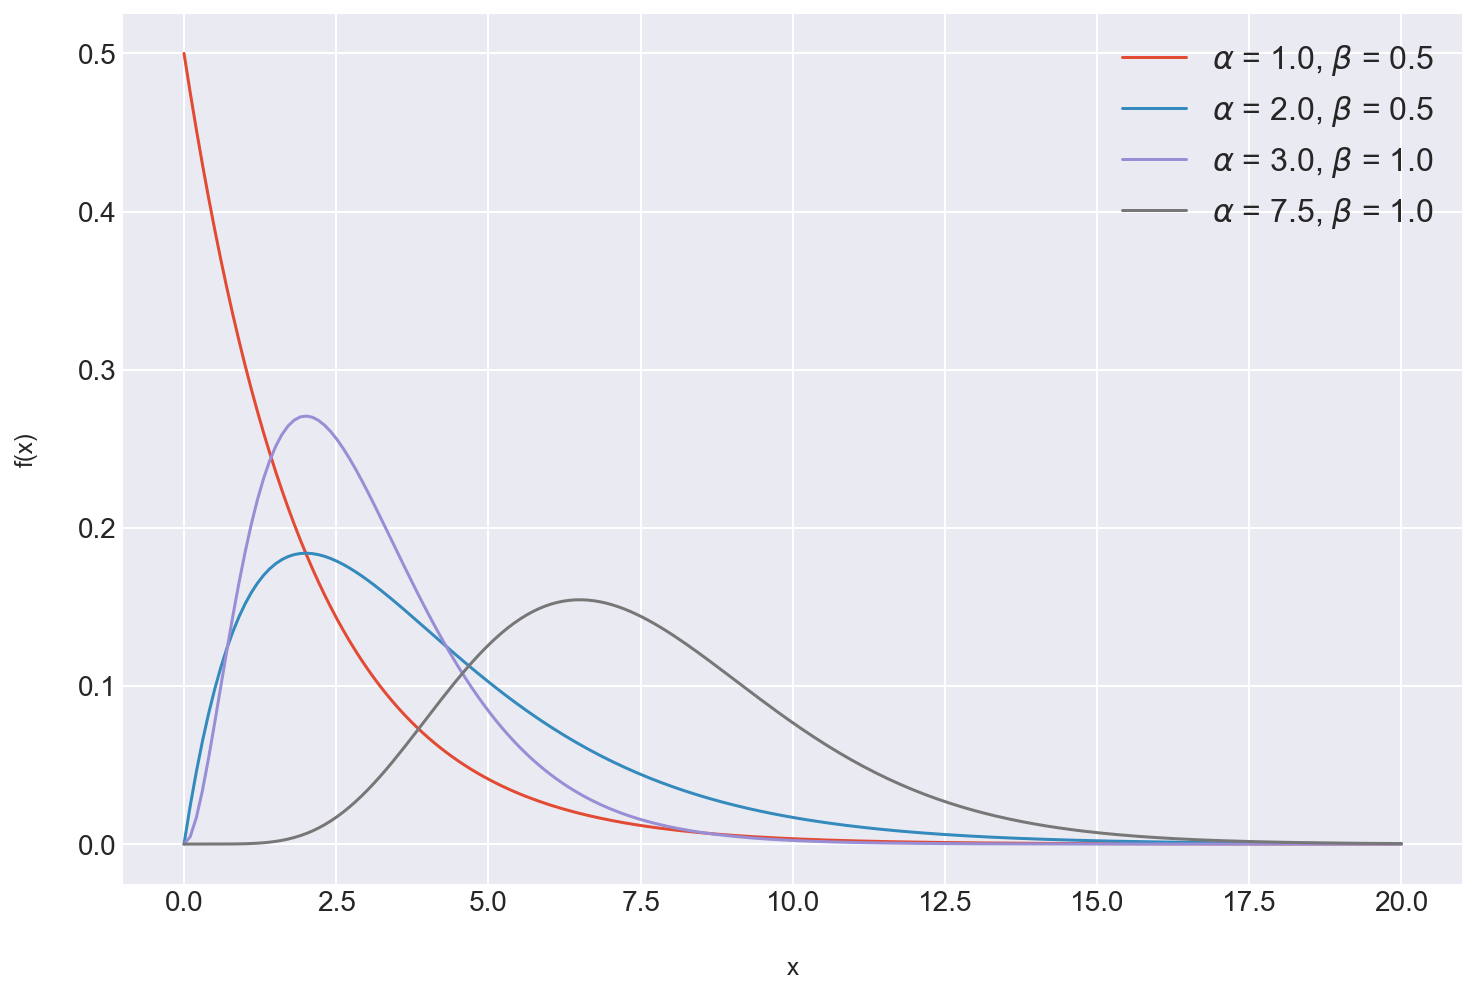

In [52]:
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 20, 200)
alphas = [1., 2., 3., 7.5]
betas = [.5, .5, 1., 1.]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

Modeling x in seconds, we'll need an order of magnitude higher than this

Note: mean = $\alpha / \beta$ and higher $\beta$ will give a tighter distribution

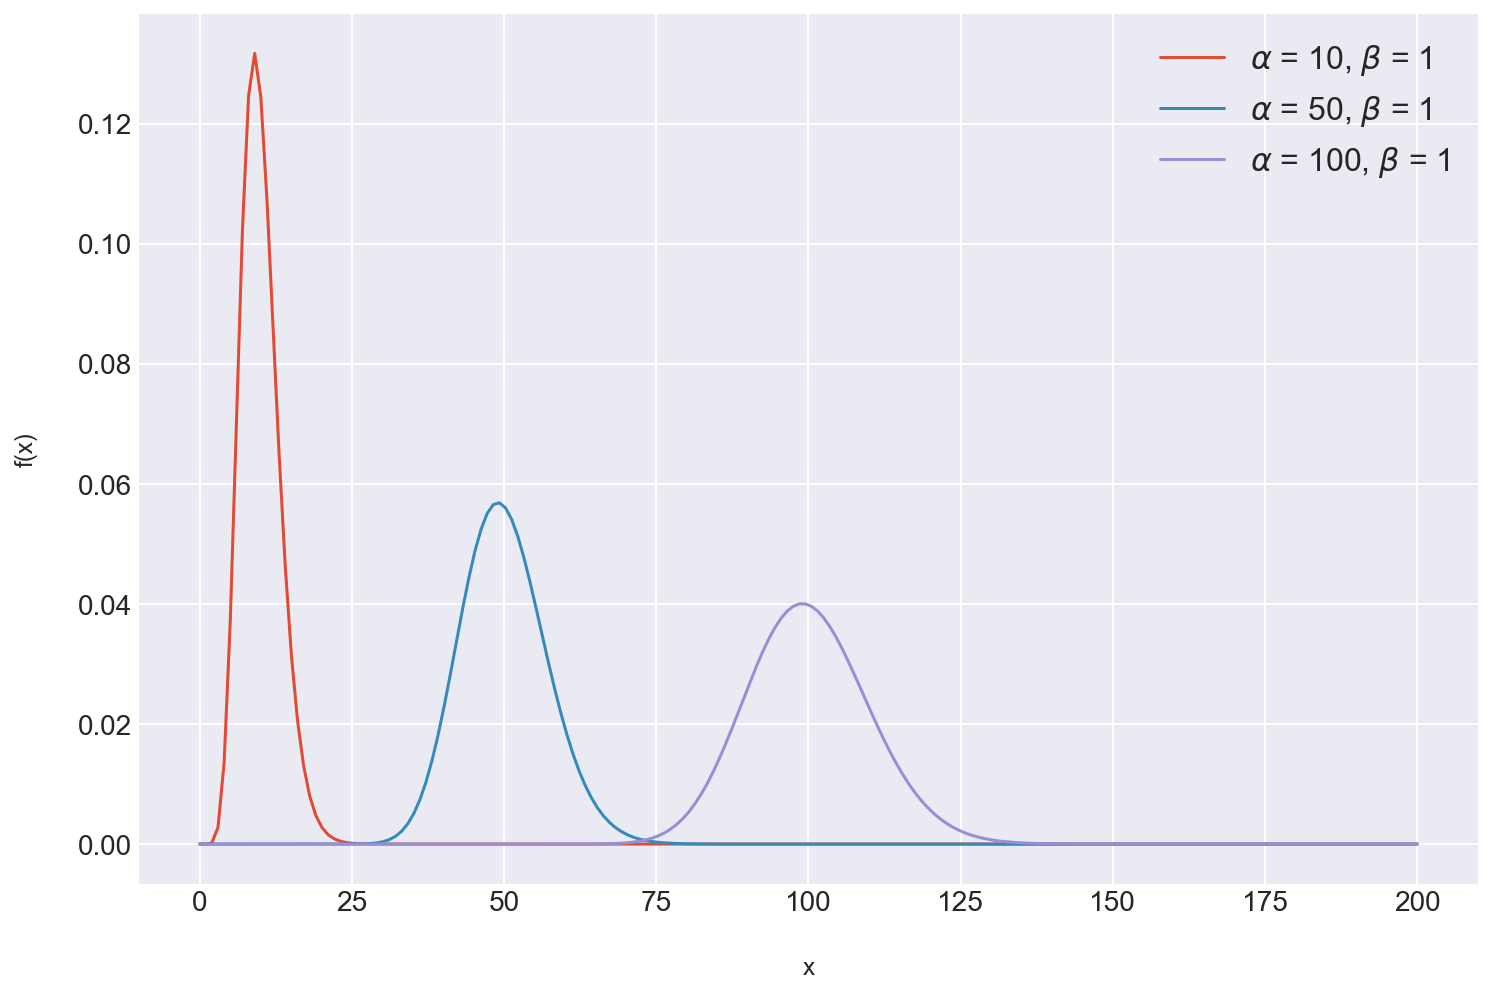

In [58]:
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 200, 200)
alphas = [10, 50, 100]
betas = [1, 1, 1]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

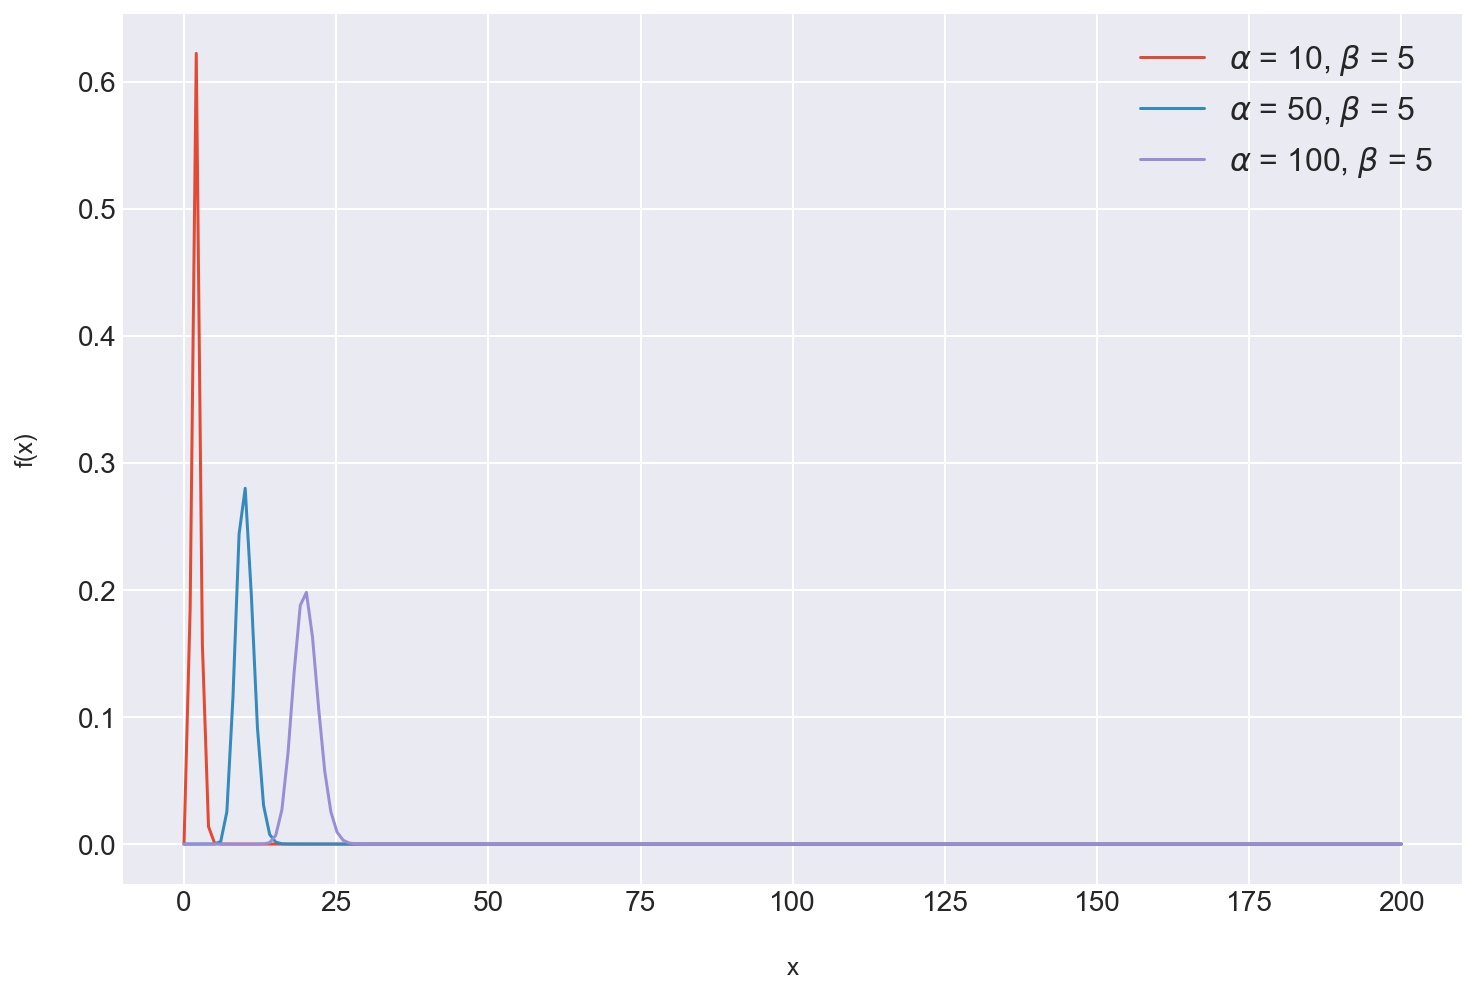

In [59]:
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 200, 200)
alphas = [10, 50, 100]
betas = [5, 5, 5]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

### Plyaing with some models

For Gamma, we'll need to "flip" the training samples

In [56]:
MAX_TIME_SECONDS = 20*60
training_samples[0] = max_time_seconds - training_samples[0]
training_samples[1] = max_time_seconds - training_samples[1]
training_samples[2] = max_time_seconds - training_samples[2]

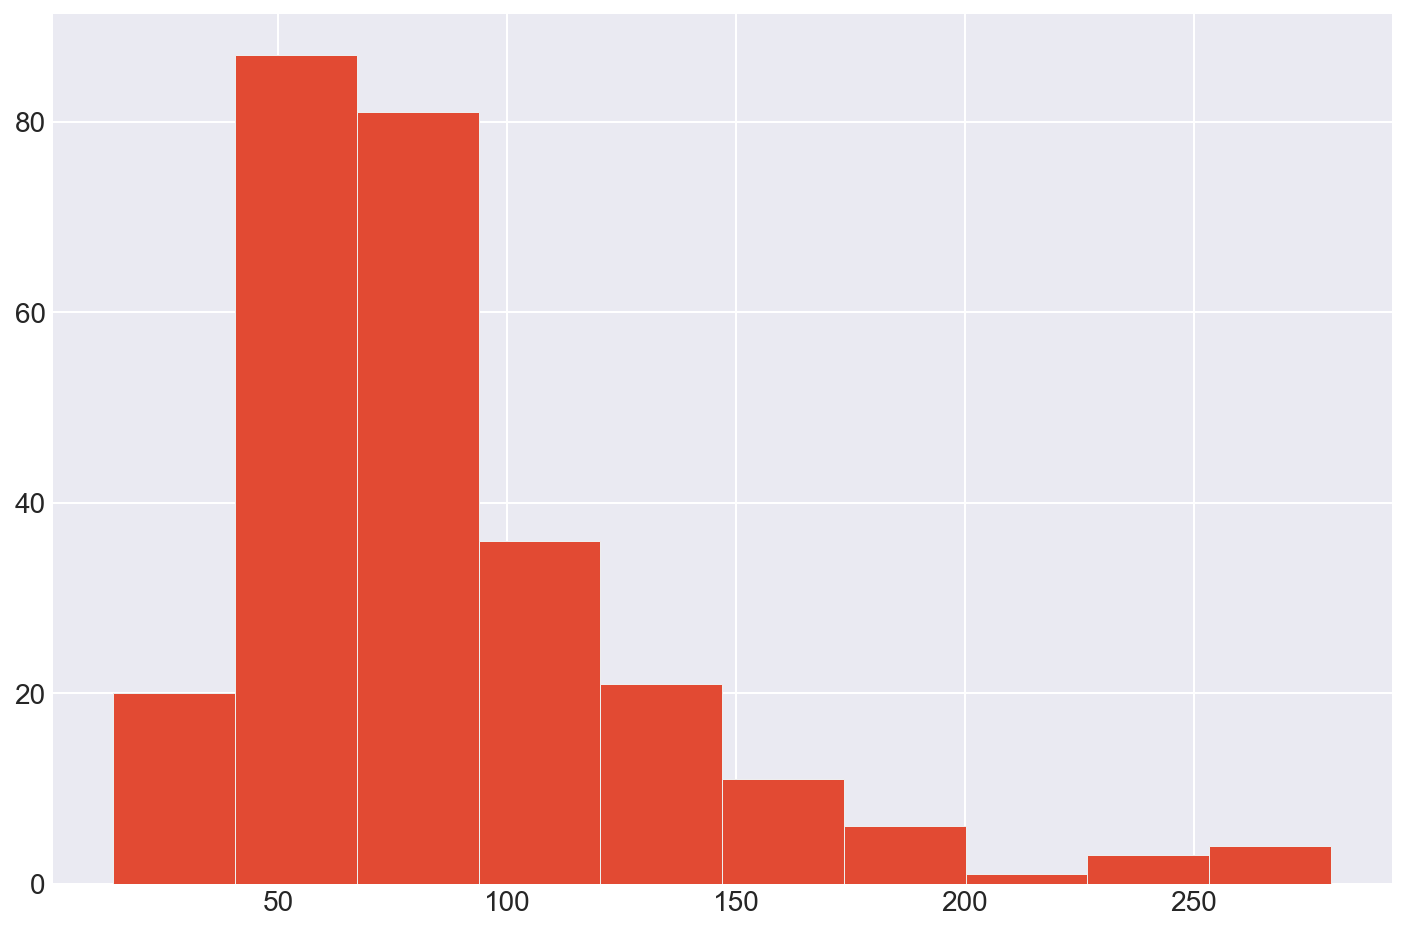

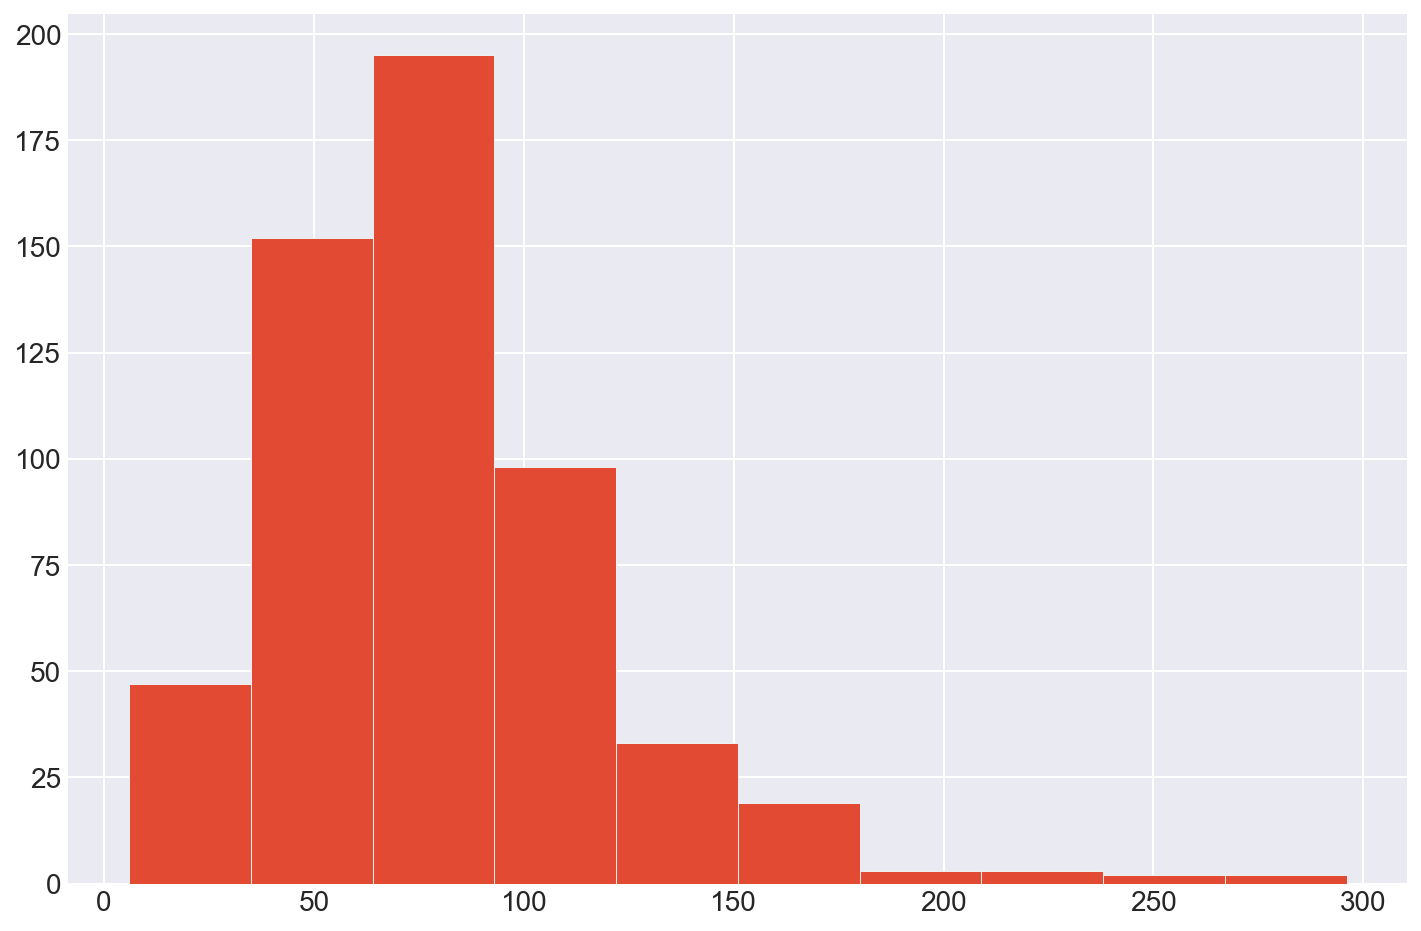

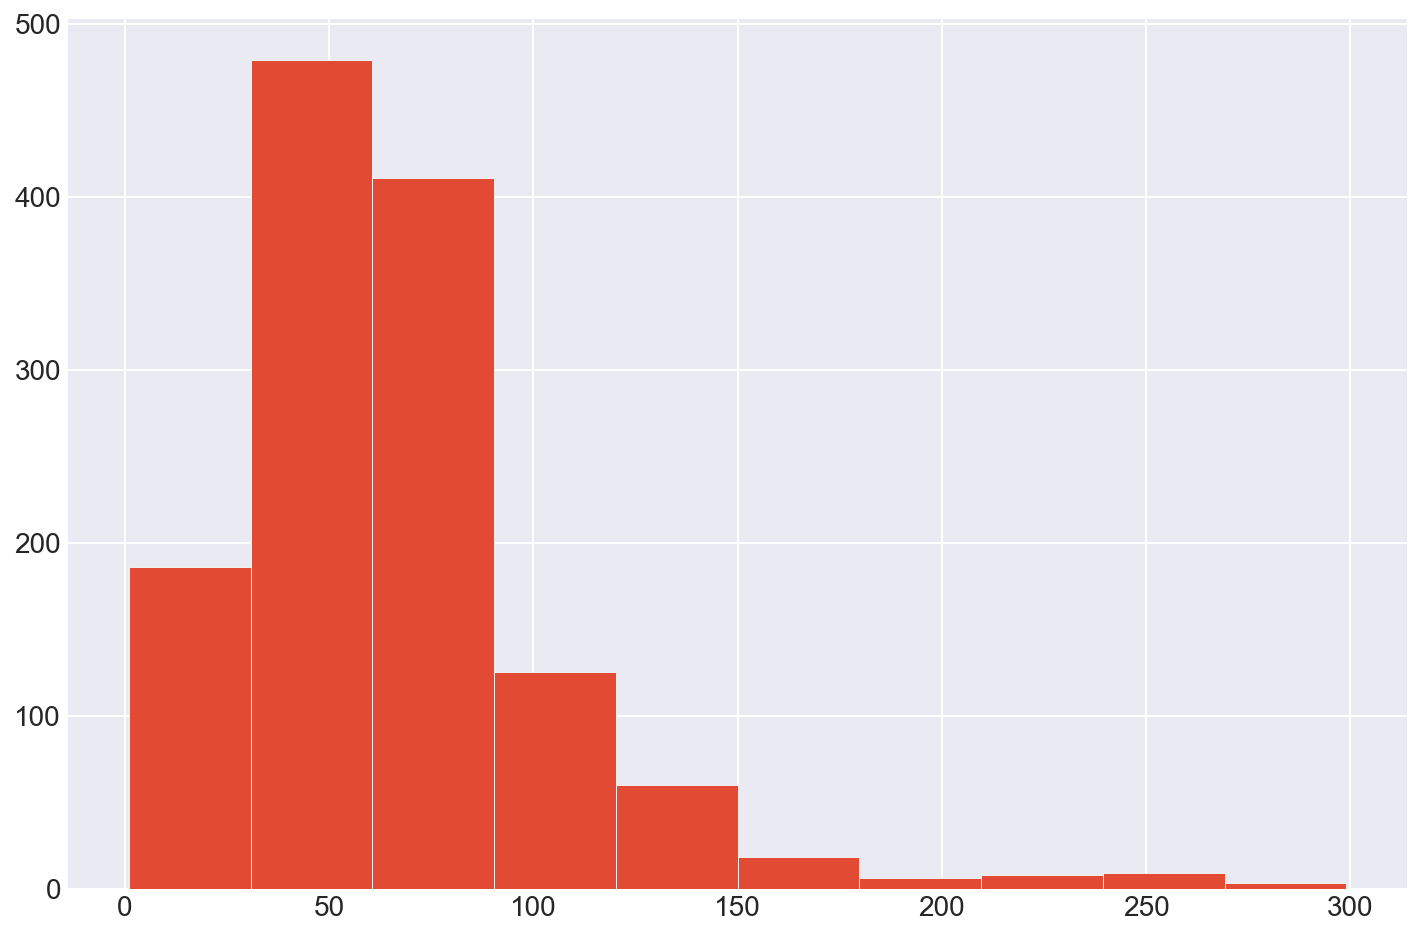

In [60]:
plt.hist(training_samples[0])
plt.show()
plt.hist(training_samples[1])
plt.show()
plt.hist(training_samples[2])
plt.show()

To start out, let's assume a huge range for the prior

In [61]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors
        beta_range = (0, 5000)
        alpha_range = (0.1, 100)
        
        beta_goal_for = pm.Uniform(
            'beta_goal_for', *beta_range
        )
        beta_goal_against = pm.Uniform(
            'beta_goal_against', *beta_range
        )
        beta_no_goal = pm.Uniform(
            'beta_no_goal', *beta_range
        )
        alpha_goal_for = pm.Uniform(
            'alpha_goal_for', *alpha_range
        )
        alpha_goal_against = pm.Uniform(
            'alpha_goal_against', *alpha_range
        )
        alpha_no_goal = pm.Uniform(
            'alpha_no_goal', *alpha_range
        )

        
        # Observations to train the model on
        obs_goal_for = pm.Gamma(
            'obs_goal_for',
            alpha=alpha_goal_for,
            beta=beta_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Gamma(
            'obs_goal_against',
            alpha=alpha_goal_against,
            beta=beta_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Gamma(
            'obs_no_goal',
            alpha=alpha_no_goal,
            beta=beta_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Gamma('p_goal_for', alpha=alpha_goal_for, beta=beta_goal_for)
        p_goal_for = pm.Gamma('p_goal_against', alpha=alpha_goal_against, beta=beta_goal_against)
        p_goal_for = pm.Gamma('p_no_goal', alpha=alpha_no_goal, beta=beta_no_goal)
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [alpha_no_goal]
>Metropolis: [alpha_goal_against]
>Metropolis: [alpha_goal_for]
>Metropolis: [beta_no_goal]
>Metropolis: [beta_goal_against]
>Metropolis: [beta_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:43<00:00, 1700.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [62]:
N_burn = 10000
burned_trace = trace[N_burn:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2e4d9c88>,
      dtype=object)

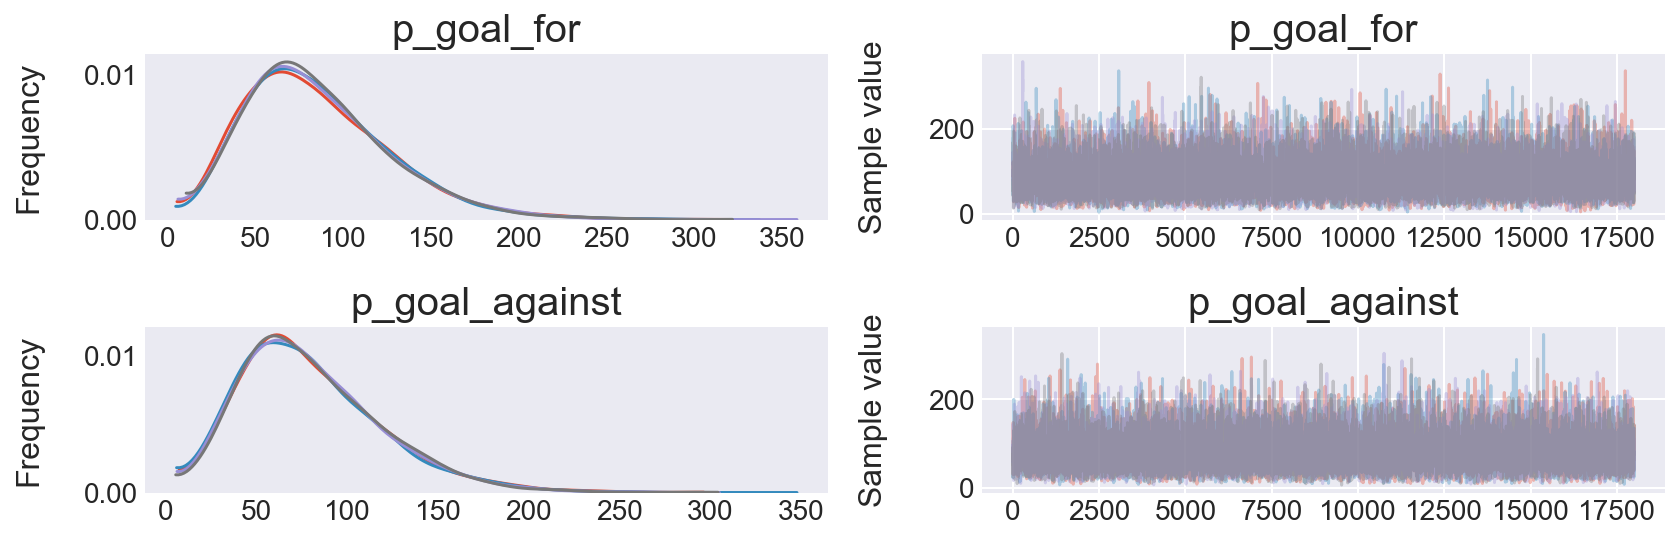

In [70]:
pm.plots.traceplot(
    trace=trace,
    varnames=['p_goal_for', 'p_goal_against']
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3459bdd8>,
      dtype=object)

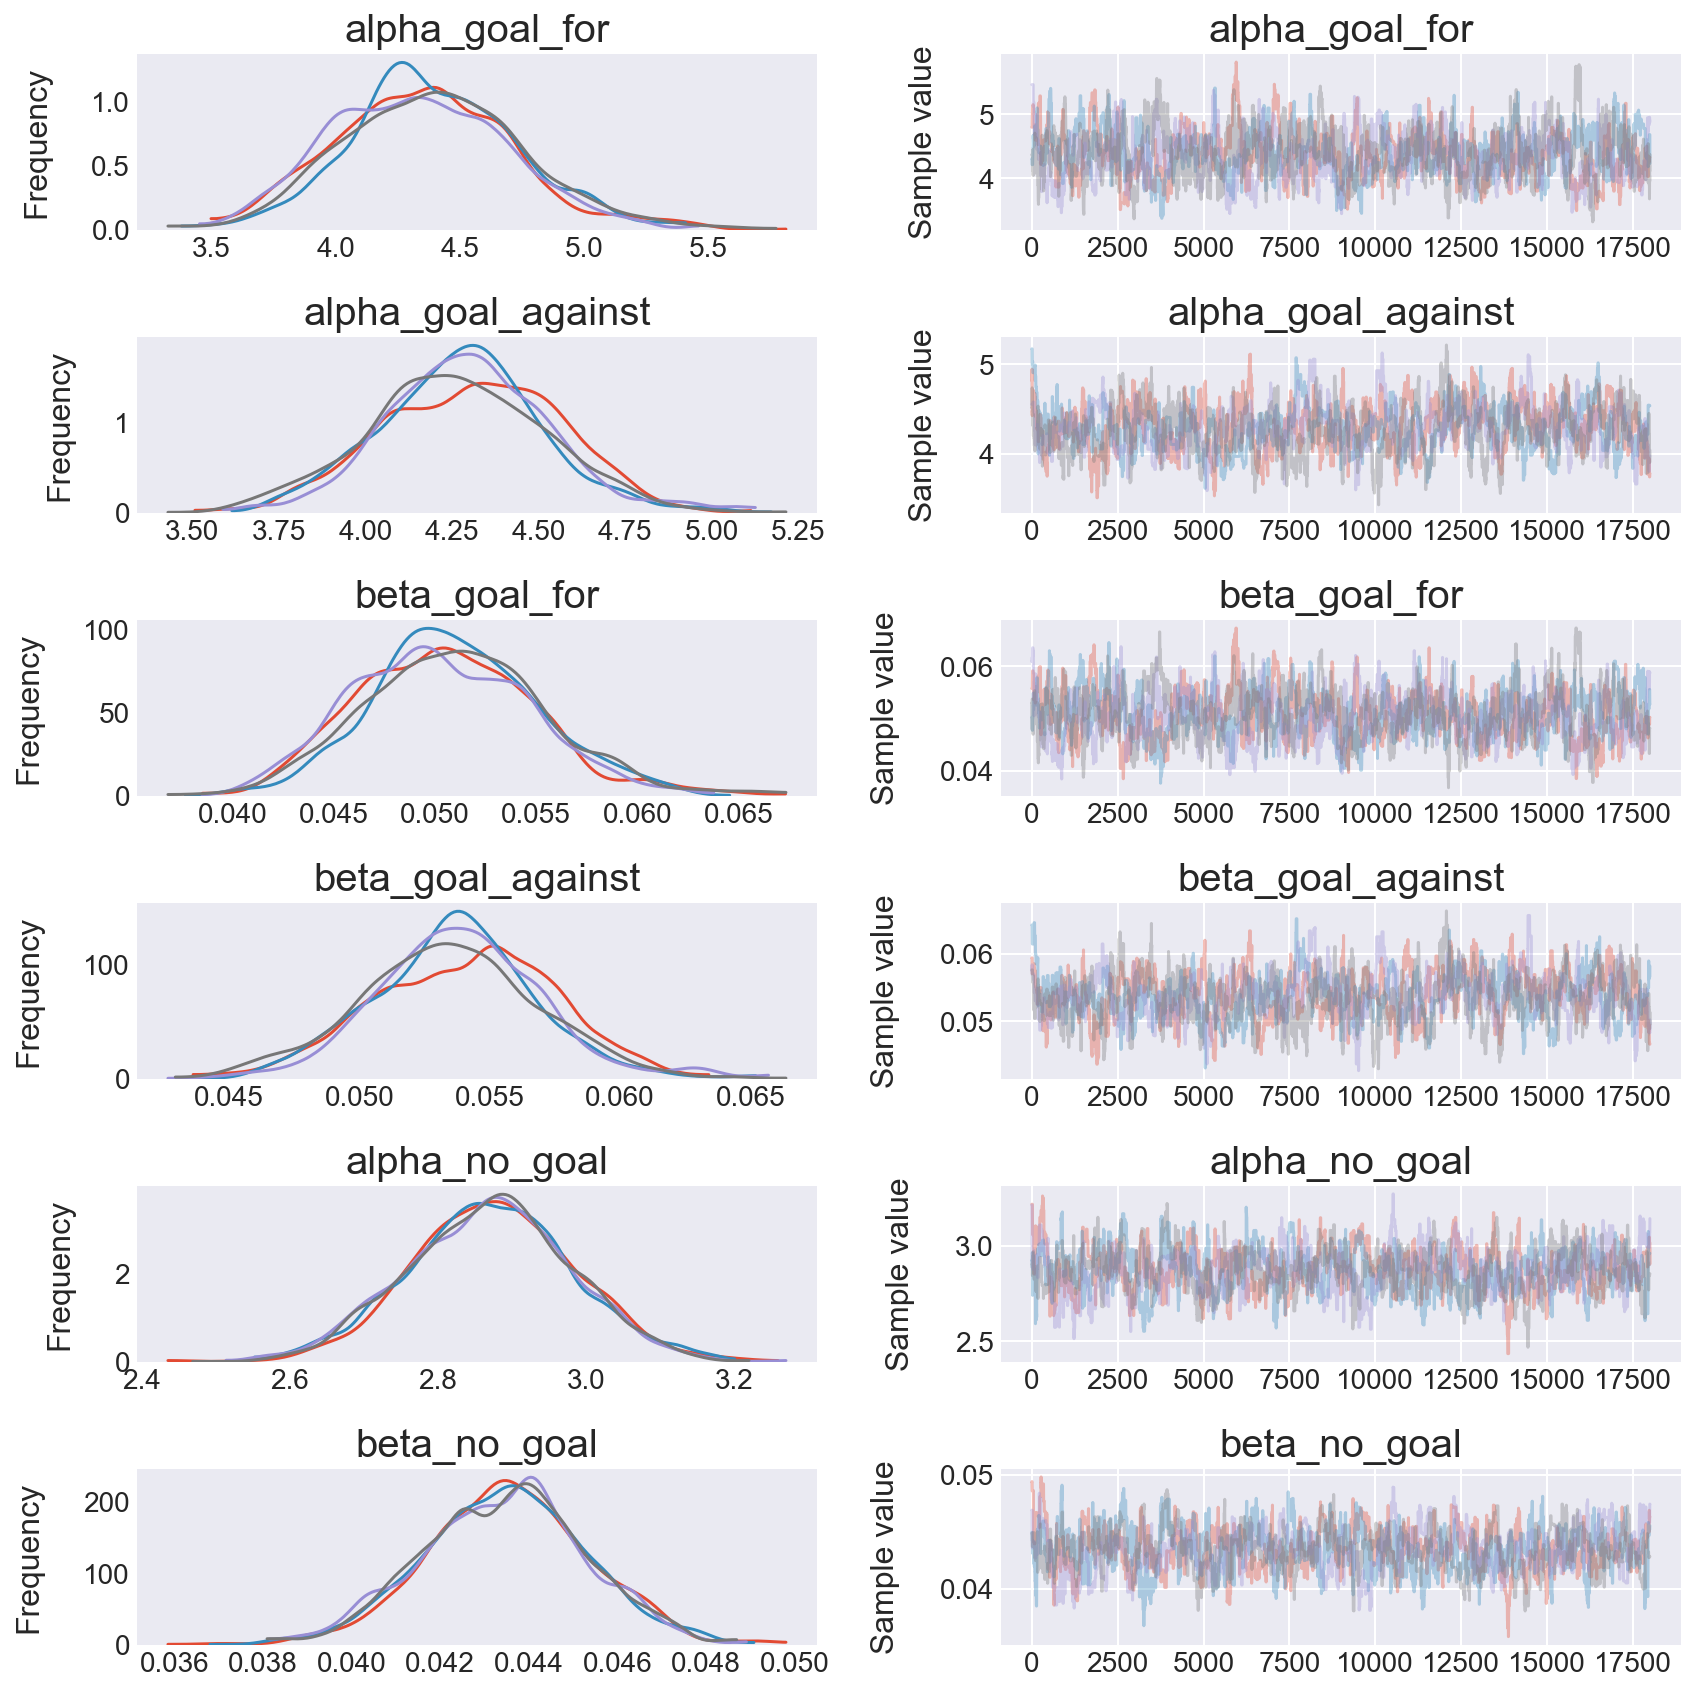

In [73]:
pm.plots.traceplot(
    trace=trace,
    varnames=['alpha_goal_for', 'alpha_goal_against',
             'beta_goal_for', 'beta_goal_against',
             'alpha_no_goal', 'beta_no_goal']
)

In [85]:
for x in ['alpha_goal_for', 'alpha_goal_against',
             'beta_goal_for', 'beta_goal_against',
             'alpha_no_goal', 'beta_no_goal']:
    print(f'{x:<30}', trace[x].mean())

alpha_goal_for                 4.36618302232362
alpha_goal_against             4.283629548511321
beta_goal_for                  0.05068210022394842
beta_goal_against              0.05370530384503524
alpha_no_goal                  2.869962433453185
beta_no_goal                   0.04344298631068073


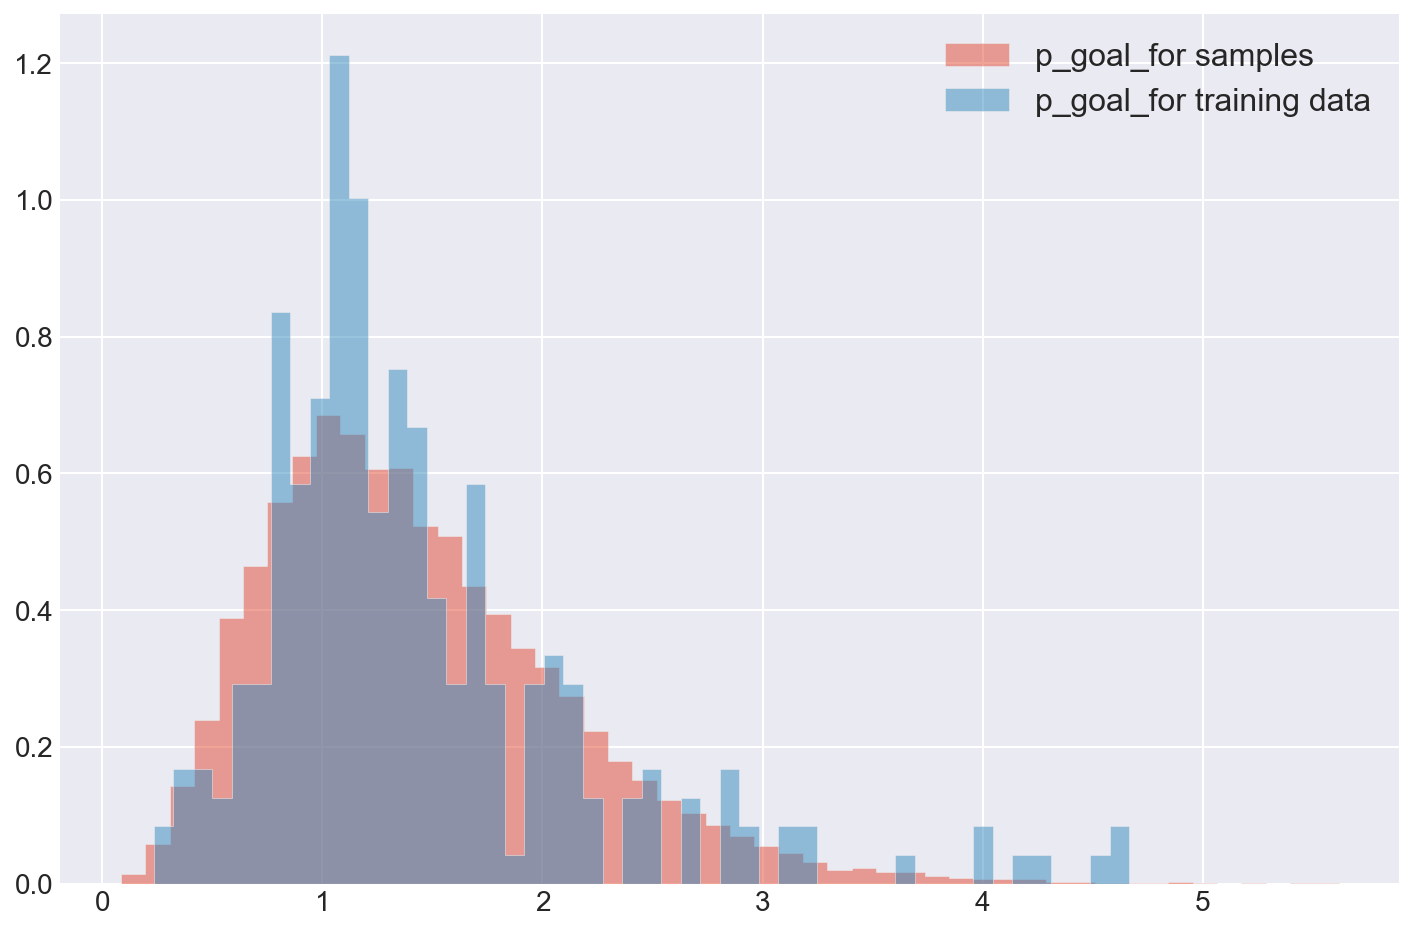

In [67]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_goal_for']/60, bins=50,
         label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[0]/60, bins=50,
         label='p_goal_for training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

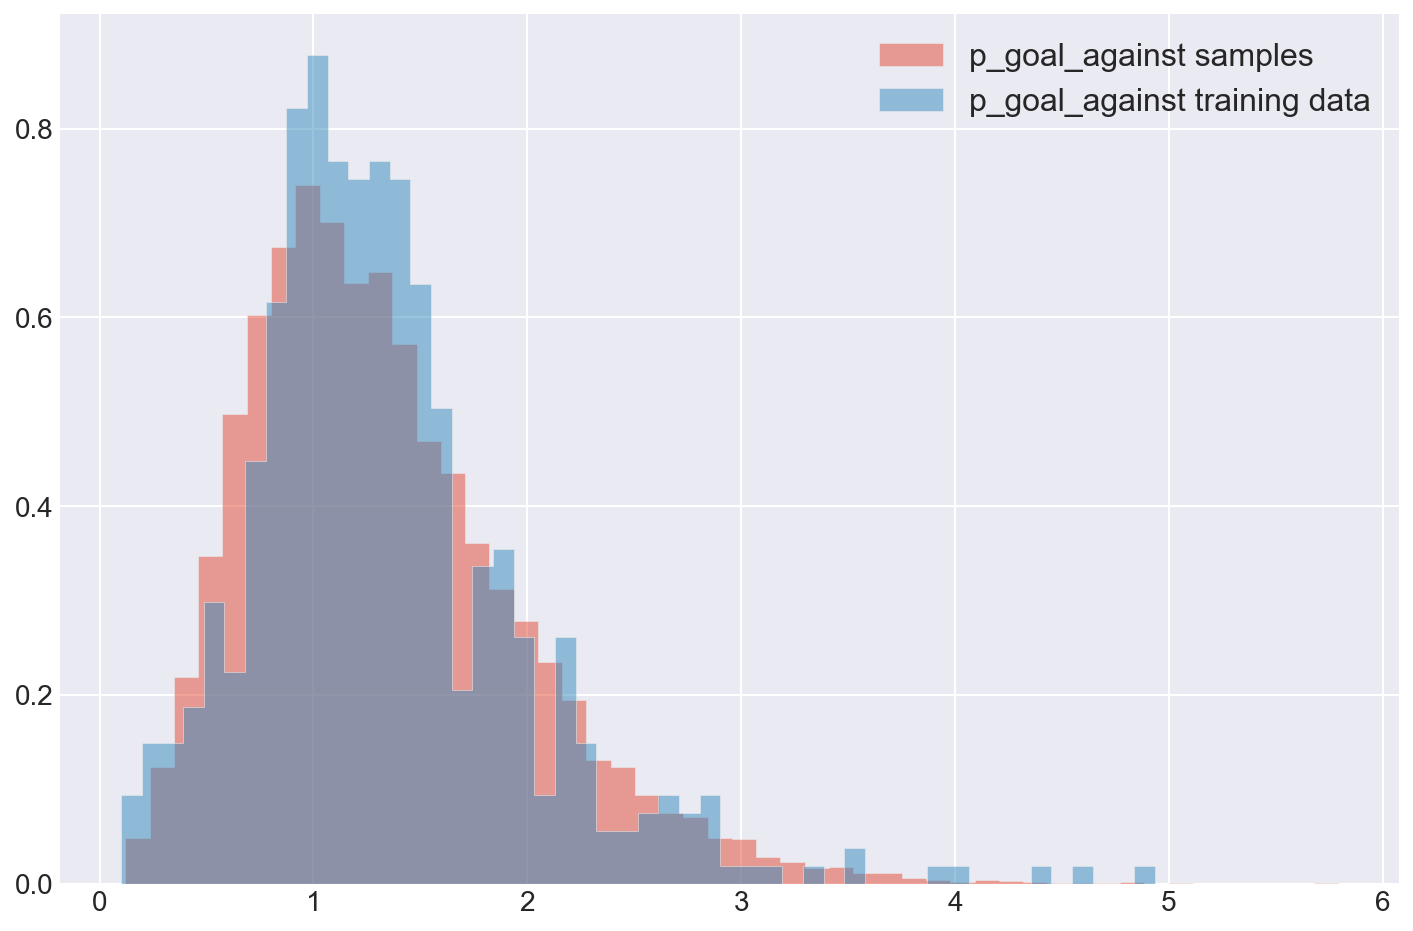

In [68]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_goal_against']/60, bins=50,
         label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[1]/60, bins=50,
         label='p_goal_against training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

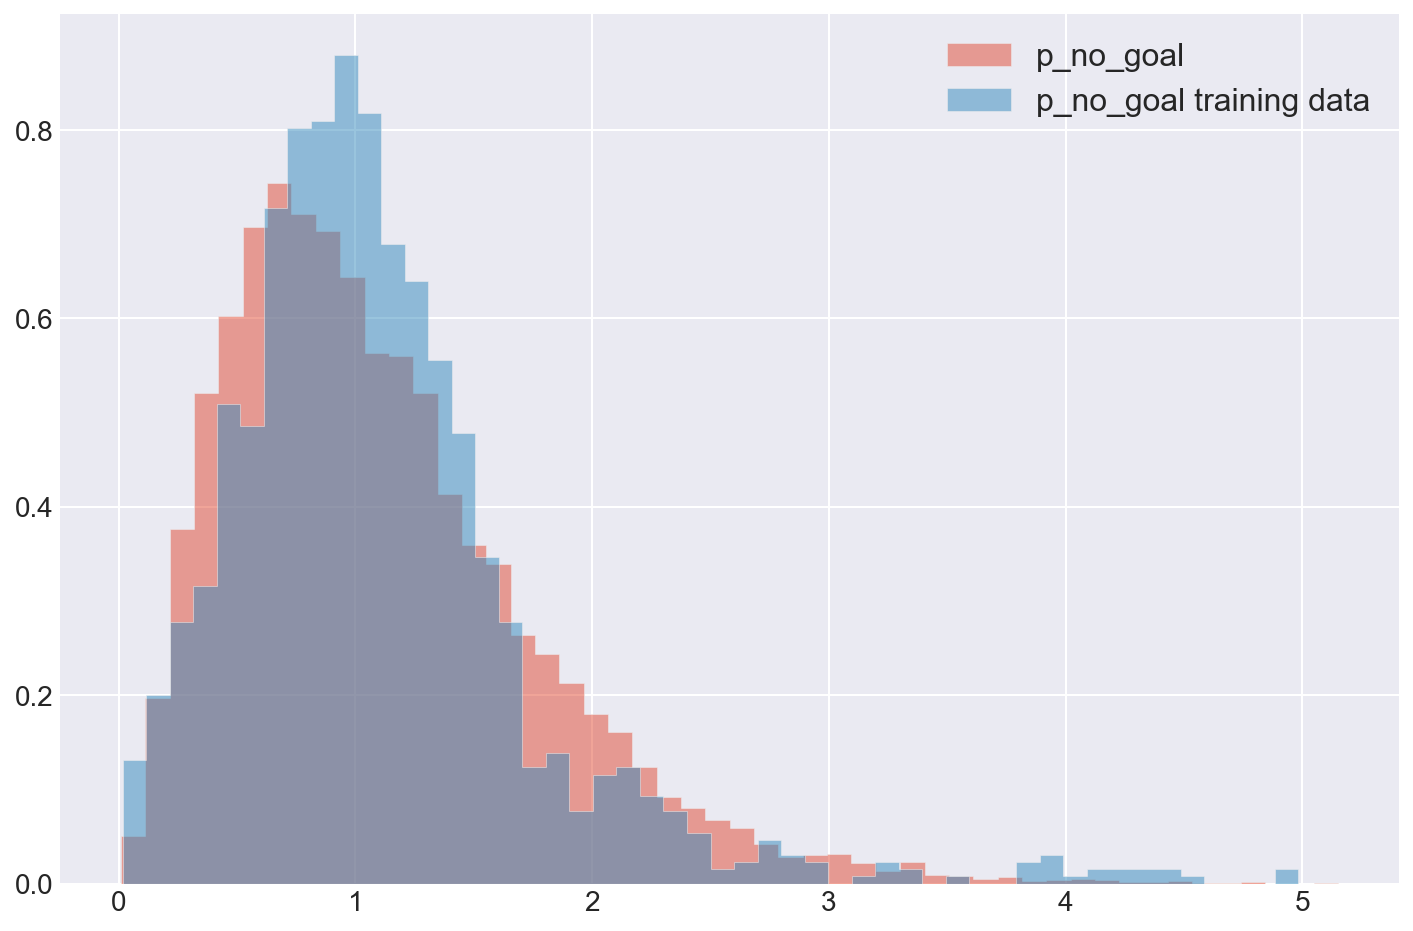

In [69]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_no_goal']/60, bins=50,
         label='p_no_goal',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[2]/60, bins=50,
         label='p_no_goal training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

---

Let's repeat this for some different priors

In [86]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors
        beta_range = (0, 100)
        alpha_range = (0.001, 10)
        
        beta_goal_for = pm.Uniform(
            'beta_goal_for', *beta_range
        )
        beta_goal_against = pm.Uniform(
            'beta_goal_against', *beta_range
        )
        beta_no_goal = pm.Uniform(
            'beta_no_goal', *beta_range
        )
        alpha_goal_for = pm.Uniform(
            'alpha_goal_for', *alpha_range
        )
        alpha_goal_against = pm.Uniform(
            'alpha_goal_against', *alpha_range
        )
        alpha_no_goal = pm.Uniform(
            'alpha_no_goal', *alpha_range
        )
        
        # Observations to train the model on
        obs_goal_for = pm.Gamma(
            'obs_goal_for',
            alpha=alpha_goal_for,
            beta=beta_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Gamma(
            'obs_goal_against',
            alpha=alpha_goal_against,
            beta=beta_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Gamma(
            'obs_no_goal',
            alpha=alpha_no_goal,
            beta=beta_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Gamma('p_goal_for', alpha=alpha_goal_for, beta=beta_goal_for)
        p_goal_for = pm.Gamma('p_goal_against', alpha=alpha_goal_against, beta=beta_goal_against)
        p_goal_for = pm.Gamma('p_no_goal', alpha=alpha_no_goal, beta=beta_no_goal)
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [alpha_no_goal]
>Metropolis: [alpha_goal_against]
>Metropolis: [alpha_goal_for]
>Metropolis: [beta_no_goal]
>Metropolis: [beta_goal_against]
>Metropolis: [beta_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:47<00:00, 1549.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [87]:
N_burn = 10000
burned_trace = trace[N_burn:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2c752ef0>,
      dtype=object)

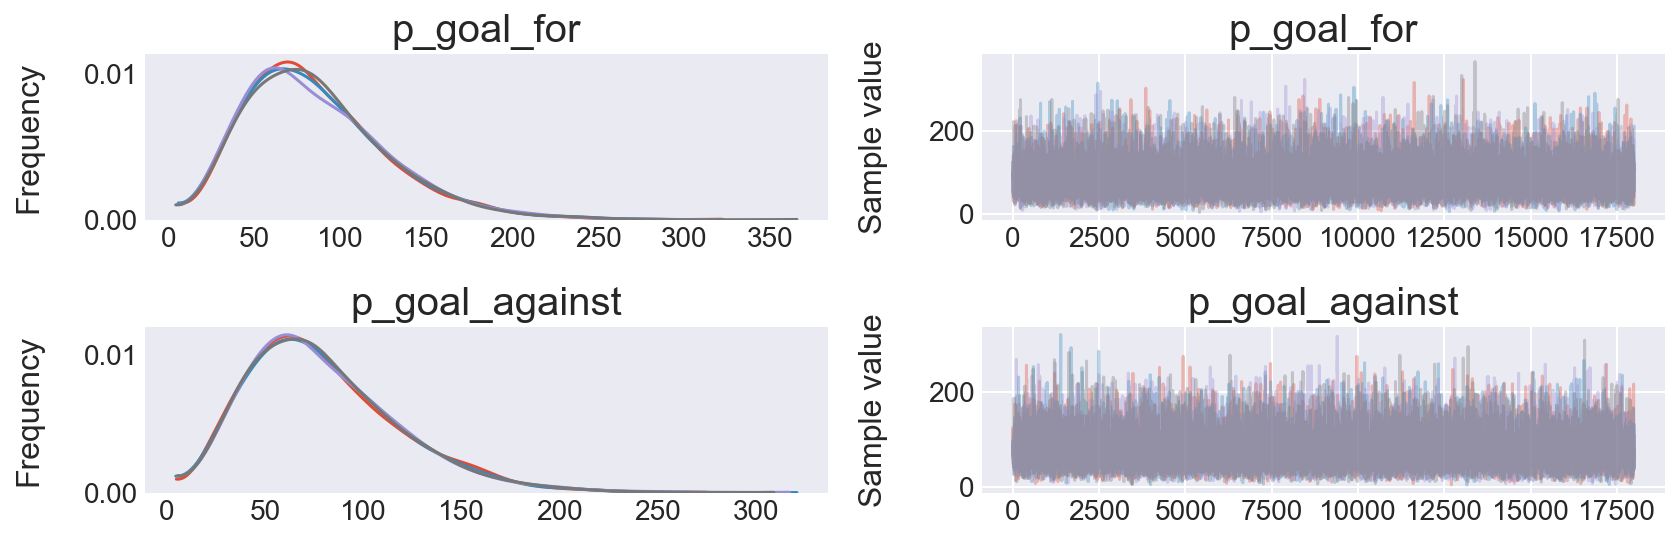

In [88]:
pm.plots.traceplot(
    trace=trace,
    varnames=['p_goal_for', 'p_goal_against']
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2fbd4e80>,
      dtype=object)

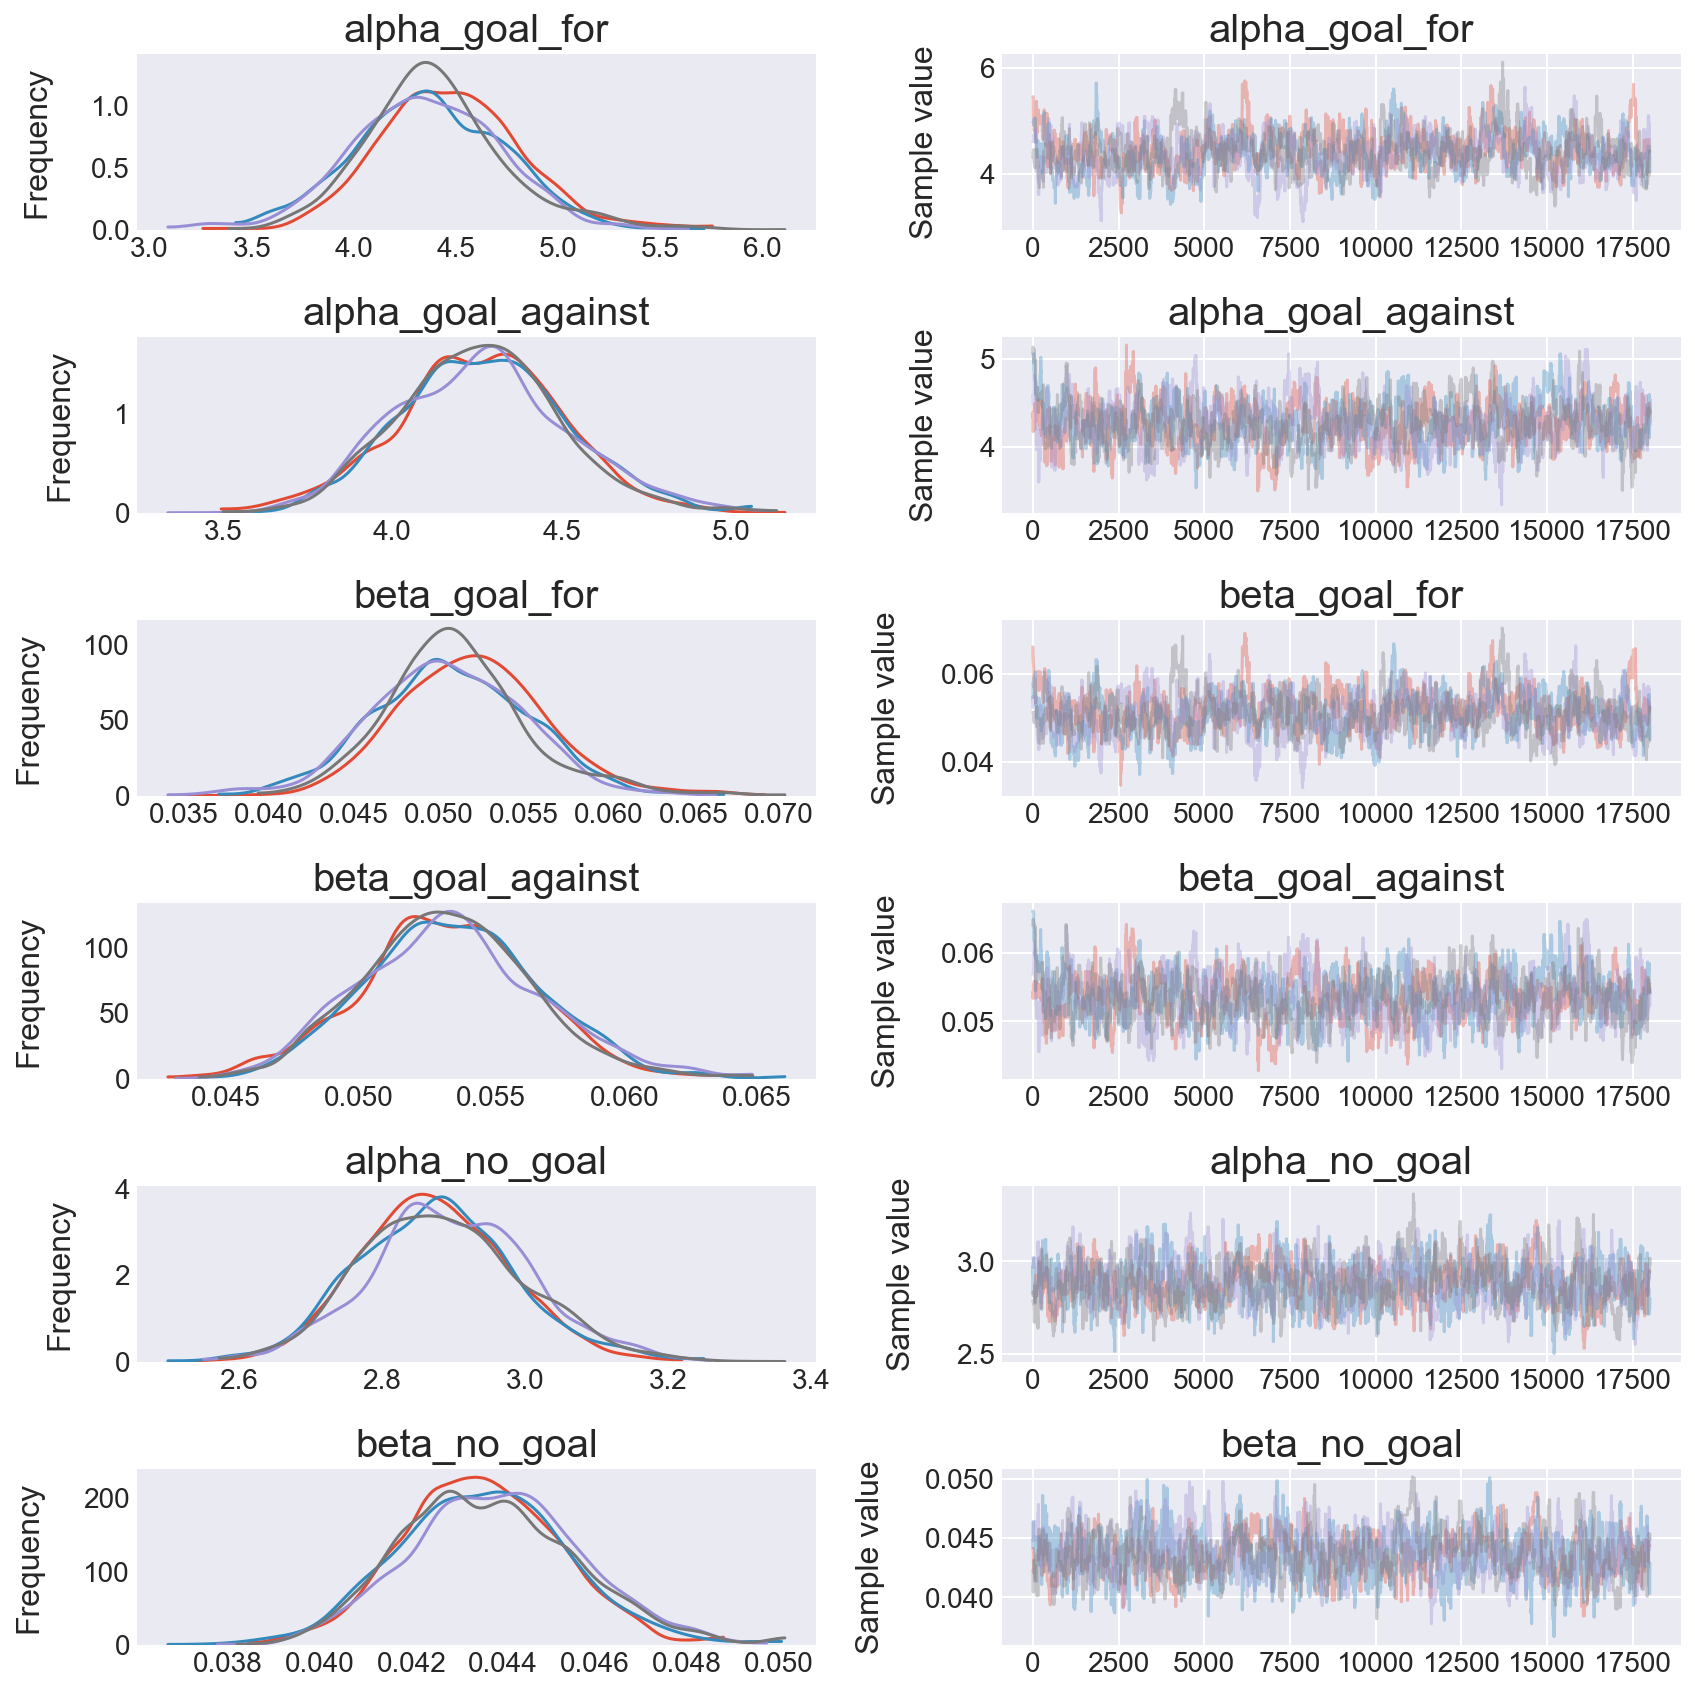

In [89]:
pm.plots.traceplot(
    trace=trace,
    varnames=['alpha_goal_for', 'alpha_goal_against',
             'beta_goal_for', 'beta_goal_against',
             'alpha_no_goal', 'beta_no_goal']
)

In [90]:
for x in ['alpha_goal_for', 'alpha_goal_against',
             'beta_goal_for', 'beta_goal_against',
             'alpha_no_goal', 'beta_no_goal']:
    print(f'{x:<30}', trace[x].mean())

alpha_goal_for                 4.393675421282651
alpha_goal_against             4.260600515663611
beta_goal_for                  0.05100356042169145
beta_goal_against              0.05339527004798347
alpha_no_goal                  2.8806498572858725
beta_no_goal                   0.0436209206981941


We converged to the same values pretty much...

Results from above:

```
alpha_goal_for                 4.36618302232362
alpha_goal_against             4.283629548511321
beta_goal_for                  0.05068210022394842
beta_goal_against              0.05370530384503524
alpha_no_goal                  2.869962433453185
beta_no_goal                   0.04344298631068073
```

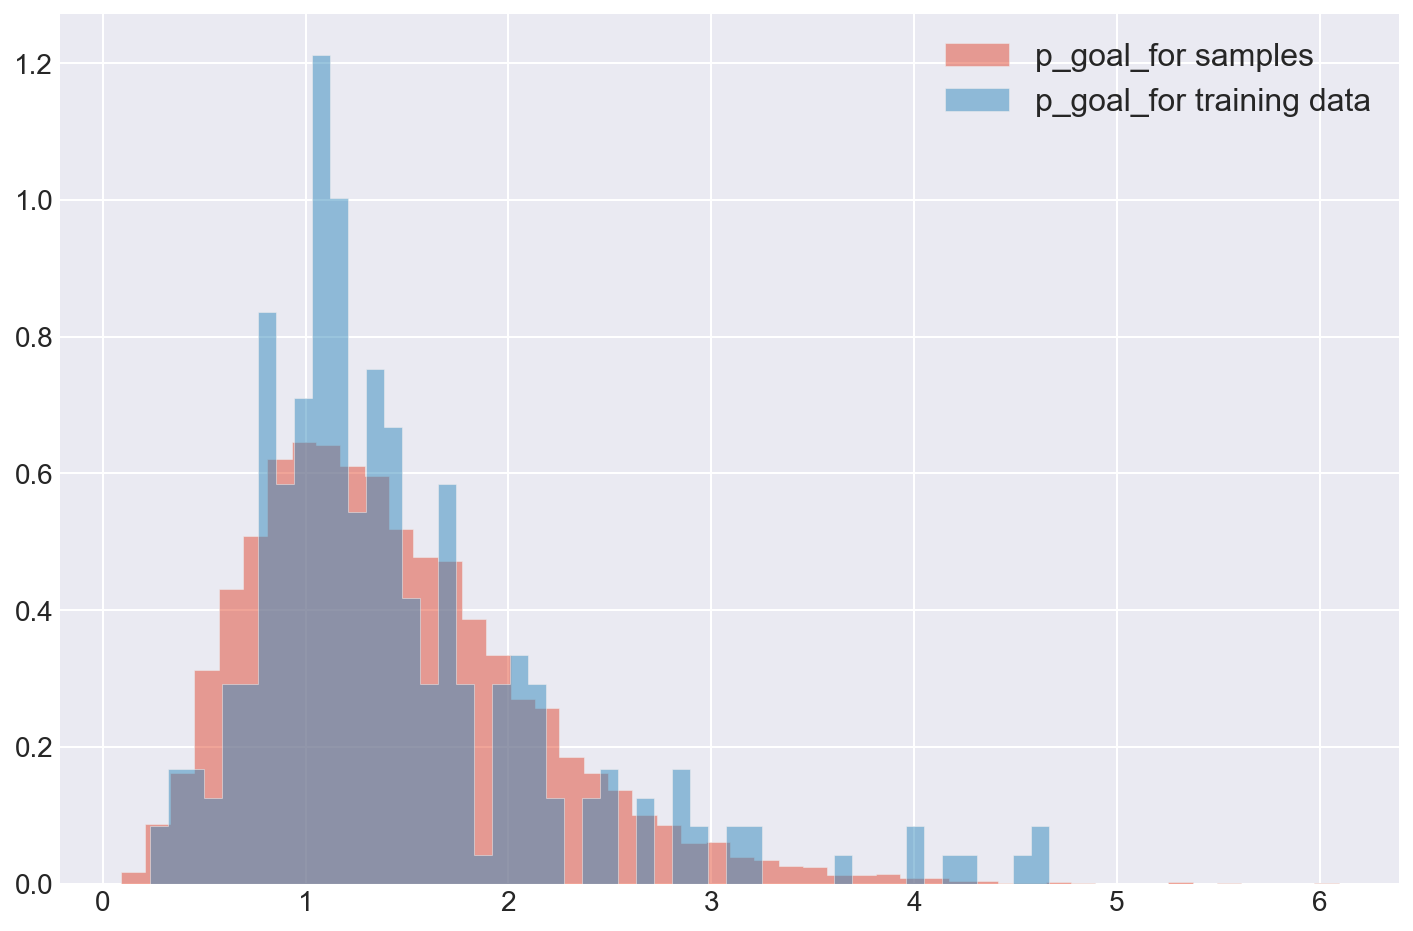

In [91]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_goal_for']/60, bins=50,
         label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[0]/60, bins=50,
         label='p_goal_for training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

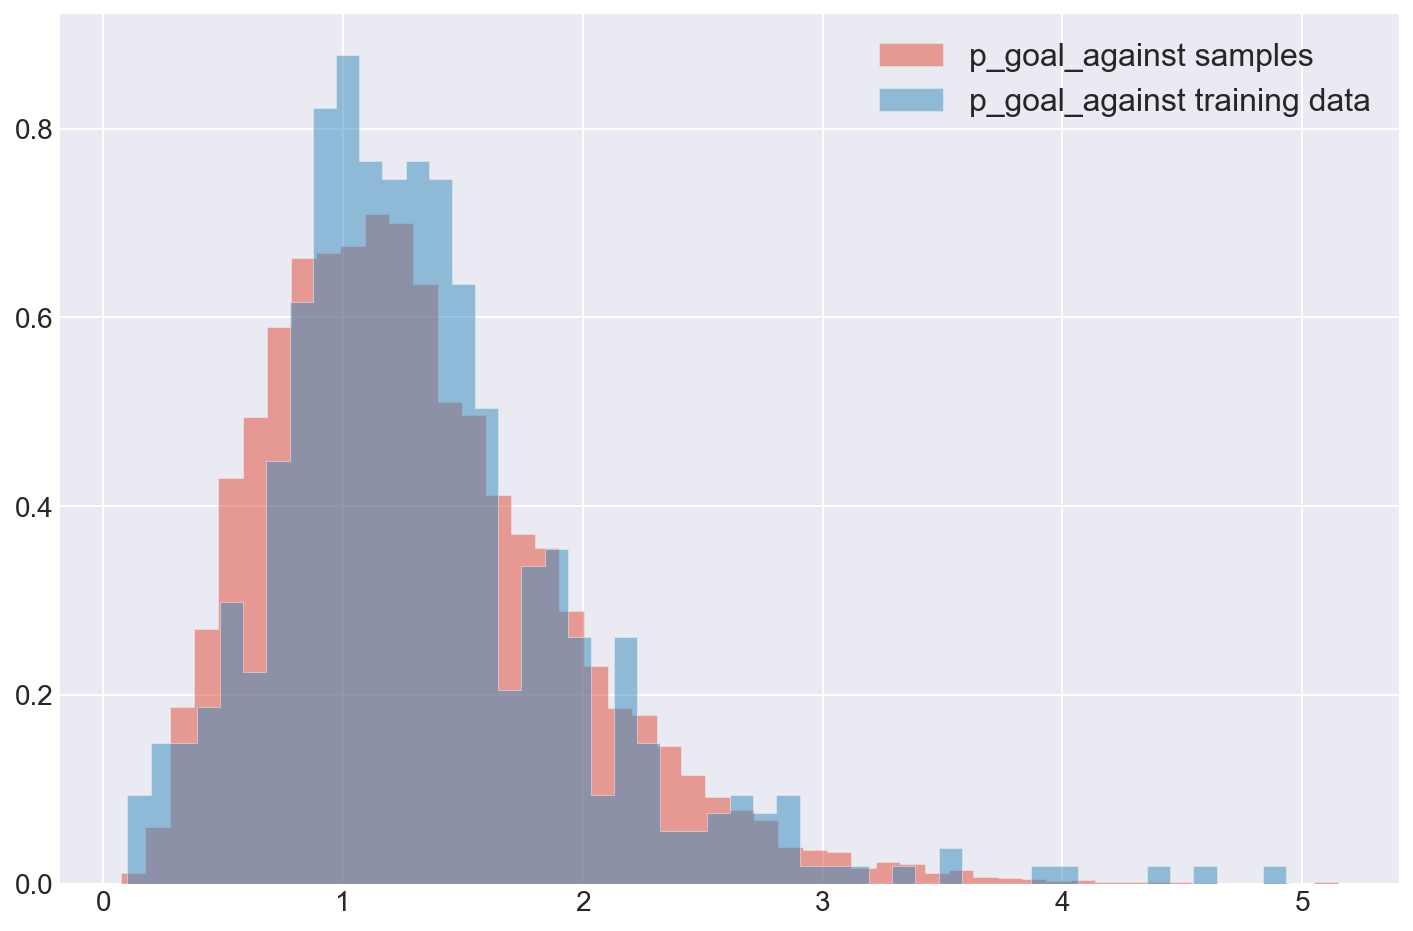

In [92]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_goal_against']/60, bins=50,
         label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[1]/60, bins=50,
         label='p_goal_against training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

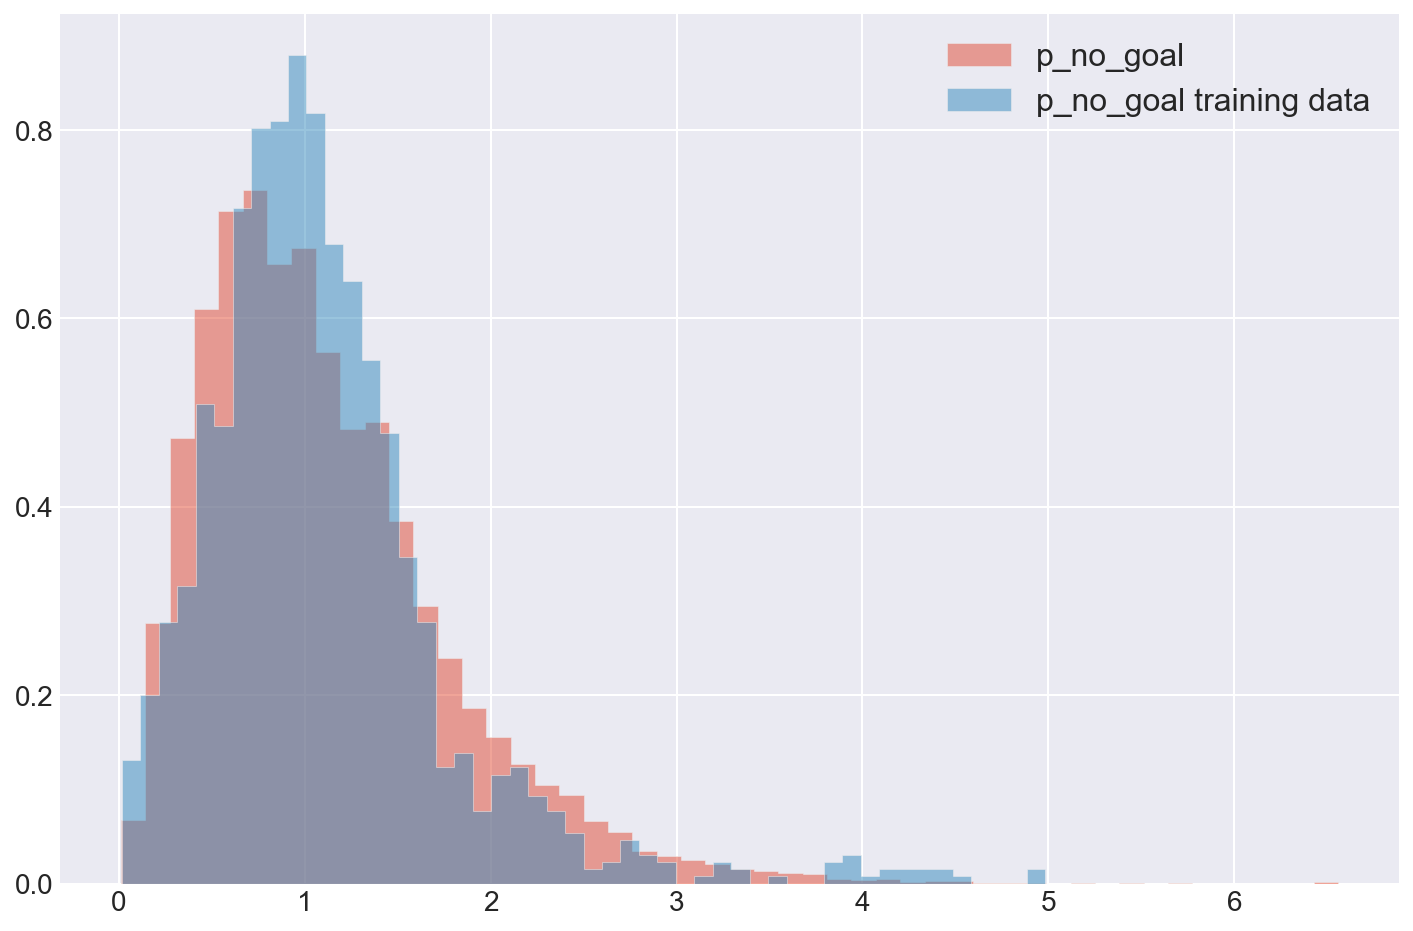

In [93]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_no_goal']/60, bins=50,
         label='p_no_goal',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[2]/60, bins=50,
         label='p_no_goal training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

### Time since model

In [181]:
# Load time of pull for eventual outcomes:
feature_names = ['goal_for_timedelta', 'goal_against_timedelta', 'game_end_timedelta']
training_samples = load_training_samples(df=df, cols=feature_names)

Loaded 270 samples for col goal_for_timedelta
Loaded 554 samples for col goal_against_timedelta
Loaded 1305 samples for col game_end_timedelta
Training data shape = (3,)


In [182]:
(training_samples[0][:10],
training_samples[1][:10],
training_samples[2][:10],)

(array([61., 10., 48., 57., 37., 62., 30., 13., 27., 39.]),
 array([ 3., 22., 13., 36., 54., 44., 23., 11., 22.,  4.]),
 array([  2.,  75., 132.,  49.,  81.,  63.,  69.,  60.,   8.,  63.]))

In [183]:
feature_names

['goal_for_timedelta', 'goal_against_timedelta', 'game_end_timedelta']

There should be no samples with t=0, otherwise MCMC does not converge.

In [184]:
for ts in training_samples:
    print((ts == 0).sum())

5
15
0


In [185]:
training_samples[0][np.where(training_samples[0]==0)] = 1
training_samples[1][np.where(training_samples[1]==0)] = 1
training_samples[2][np.where(training_samples[2]==0)] = 1

In [186]:
for ts in training_samples:
    print((ts == 0).sum())

0
0
0


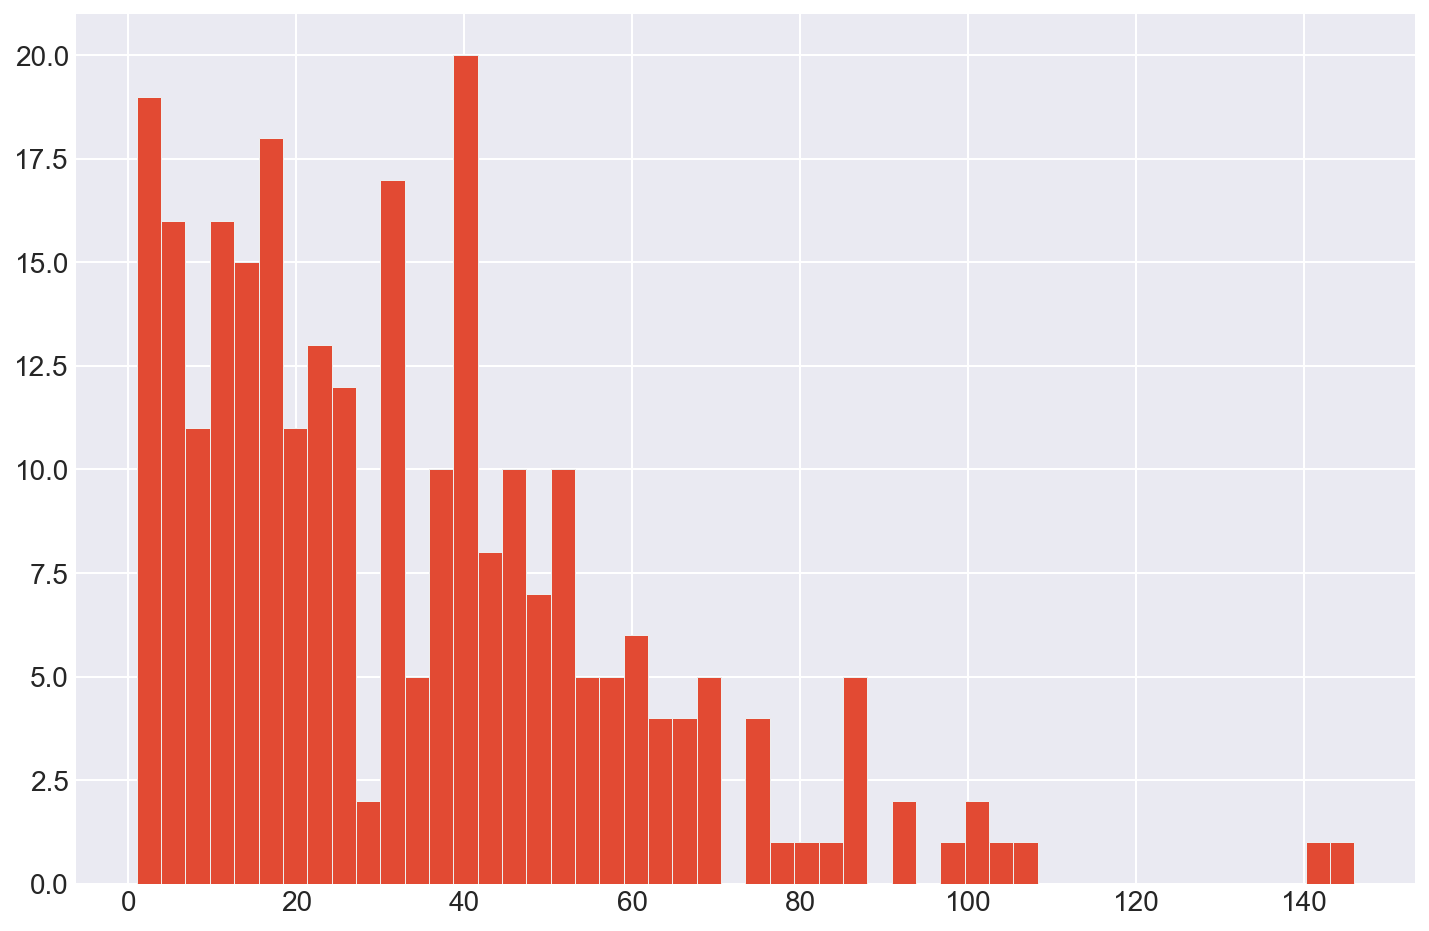

In [187]:
plt.hist(training_samples[0], bins=50);

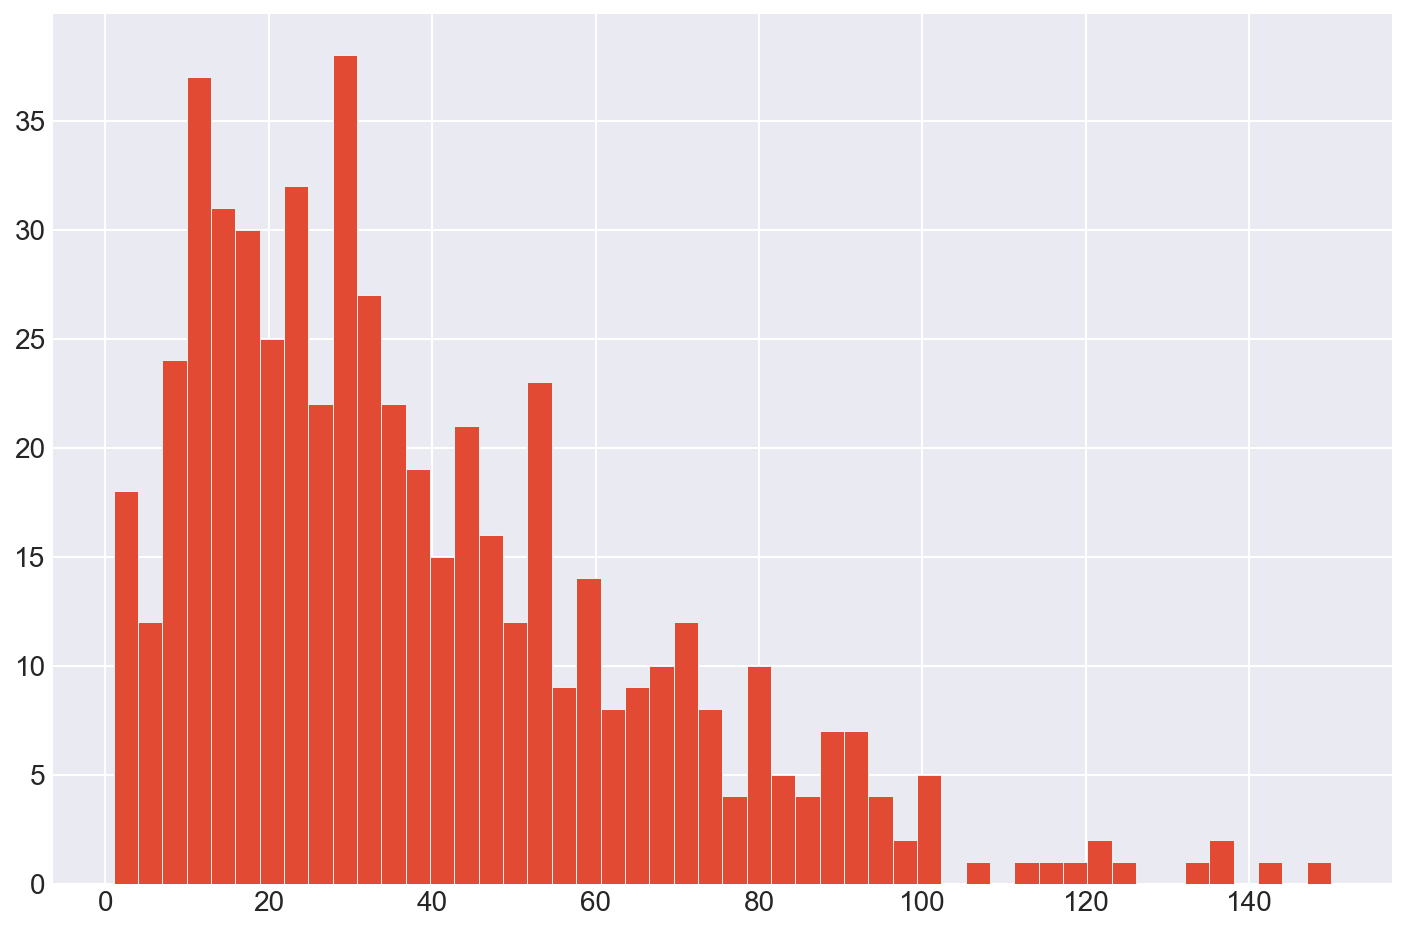

In [188]:
plt.hist(training_samples[1], bins=50);

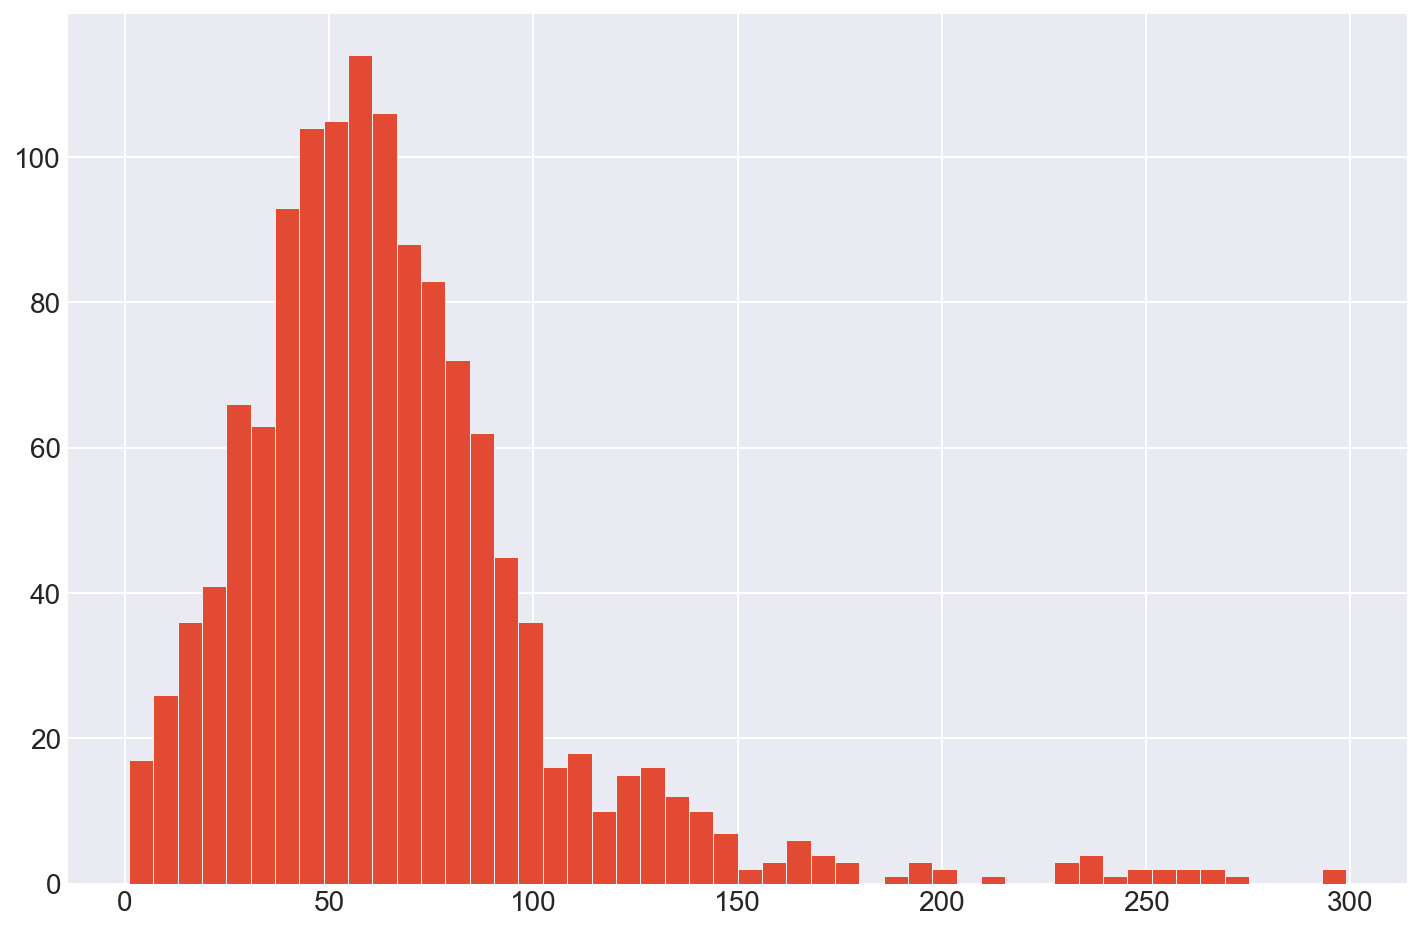

In [189]:
plt.hist(training_samples[2], bins=50);

In [190]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors
        beta_range = (0, 1000)
        alpha_range = (0.0001, 100)
        beta_goal_for = pm.Uniform(
            'beta_goal_for', *beta_range
        )
        beta_goal_against = pm.Uniform(
            'beta_goal_against', *beta_range
        )
        beta_no_goal = pm.Uniform(
            'beta_no_goal', *beta_range
        )
        alpha_goal_for = pm.Uniform(
            'alpha_goal_for', *alpha_range
        )
        alpha_goal_against = pm.Uniform(
            'alpha_goal_against', *alpha_range
        )
        alpha_no_goal = pm.Uniform(
            'alpha_no_goal', *alpha_range
        )
        
        # Observations to train the model on
        obs_goal_for = pm.Gamma(
            'obs_goal_for',
            alpha=alpha_goal_for,
            beta=beta_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Gamma(
            'obs_goal_against',
            alpha=alpha_goal_against,
            beta=beta_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Gamma(
            'obs_no_goal',
            alpha=alpha_no_goal,
            beta=beta_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Gamma(
            'p_goal_for', 
            alpha=alpha_goal_for,
            beta=beta_goal_for,
        )
        p_goal_against = pm.Gamma(
            'p_goal_against',
            alpha=alpha_goal_against,
            beta=beta_goal_against,
        )
        p_no_goal = pm.Gamma(
            'p_no_goal',
            alpha=alpha_no_goal,
            beta=beta_no_goal,
        )
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(1800, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [alpha_no_goal]
>Metropolis: [alpha_goal_against]
>Metropolis: [alpha_goal_for]
>Metropolis: [beta_no_goal]
>Metropolis: [beta_goal_against]
>Metropolis: [beta_goal_for]
Sampling 4 chains: 100%|██████████| 9200/9200 [00:05<00:00, 1681.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [191]:
N_burn = 100
burned_trace = trace[N_burn:]

In [192]:
# from typing import Tuple
# from scipy.stats import gamma

# def gamma_posterior(
#     alpha=None,
#     beta=None,
#     norm_factors=None,
# ) -> Tuple[np.ndarray]:

#     p = gamma.pdf
#     x = np.arange(0*60, 5*60, 1)
#     if alpha is None or beta is None:
#         return (x / 60,)

#     y_goal_for = p(x, alpha[0], scale=1/beta[0])
#     y_goal_against = p(x, alpha[1], scale=1/beta[1])
#     y_no_goal = p(x, alpha[2], scale=1/beta[2])
    
#     if norm_factors is not None:
#         y_goal_for = y_goal_for * norm_factors[0]
#         y_goal_against = y_goal_against * norm_factors[1]
#         y_no_goal = y_no_goal * norm_factors[2]
    
#     # Convert into minutes
#     x = x / 60

#     return x, y_goal_for, y_goal_against, y_no_goal


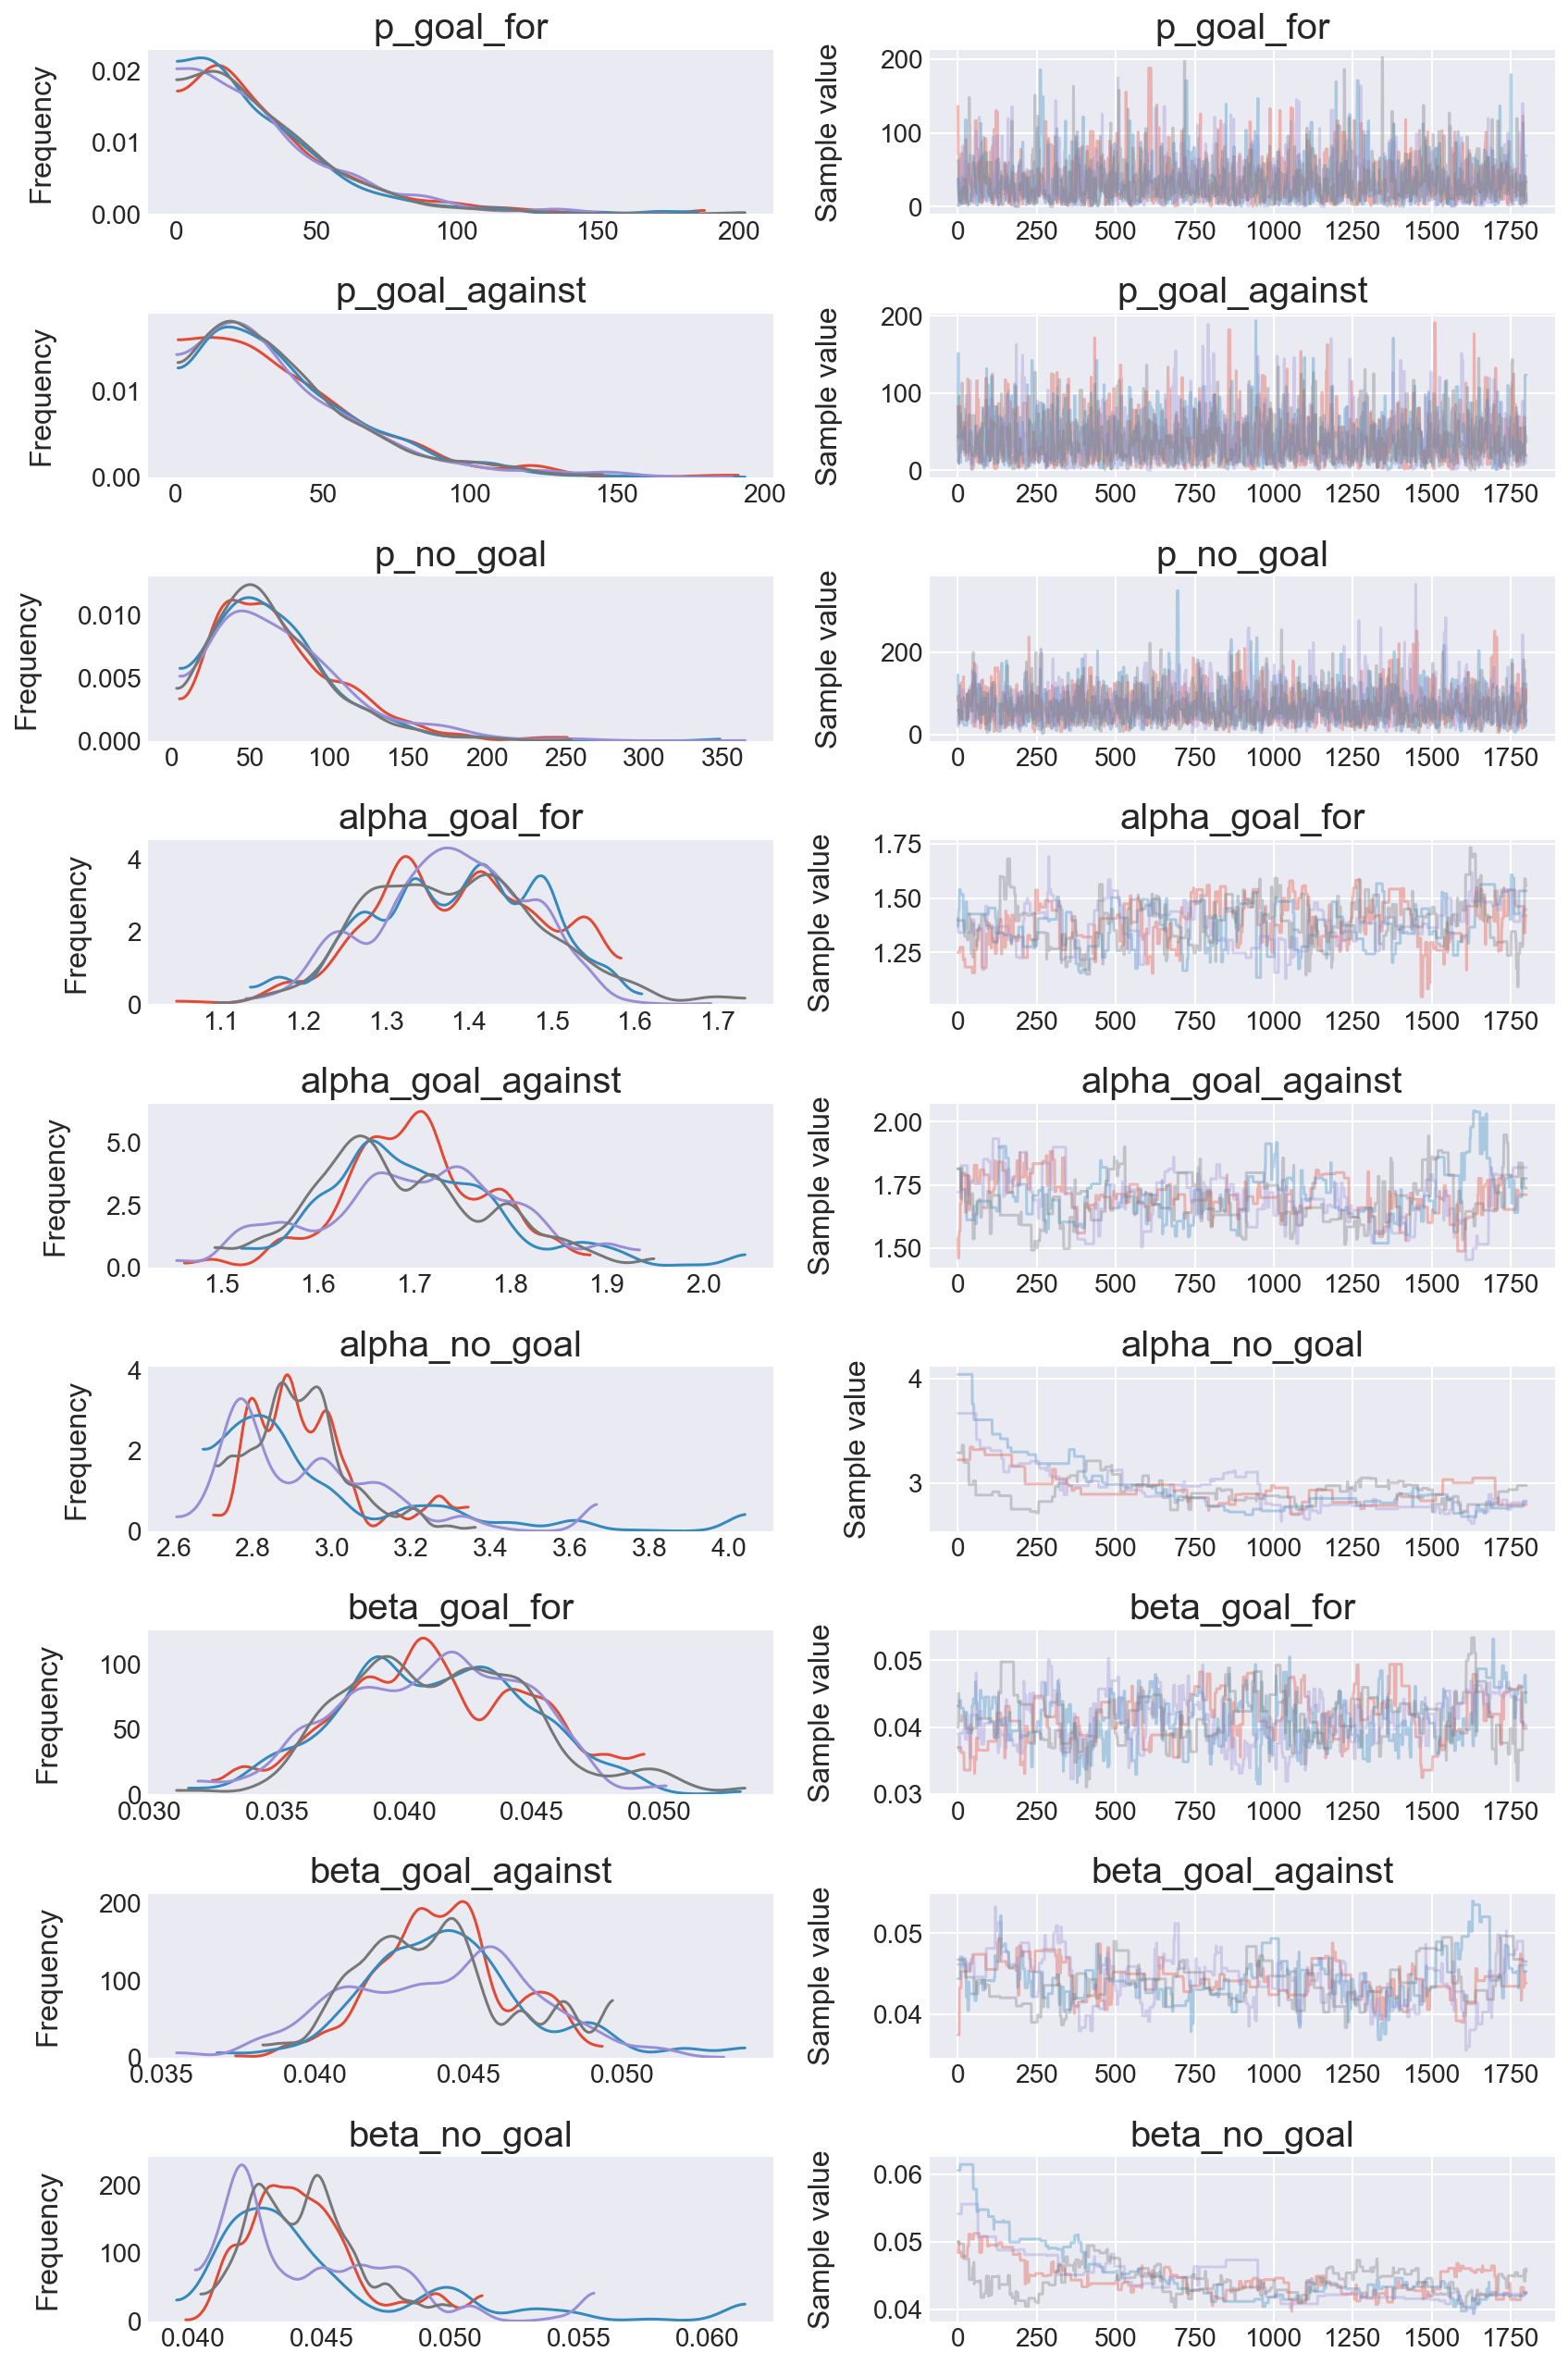

In [193]:
pm.plots.traceplot(
    trace=trace,
    varnames=[
        'p_goal_for',
        'p_goal_against',
        'p_no_goal',
        'alpha_goal_for',
        'alpha_goal_against',
        'alpha_no_goal',
        'beta_goal_for',
        'beta_goal_against',
        'beta_no_goal',
    ]);

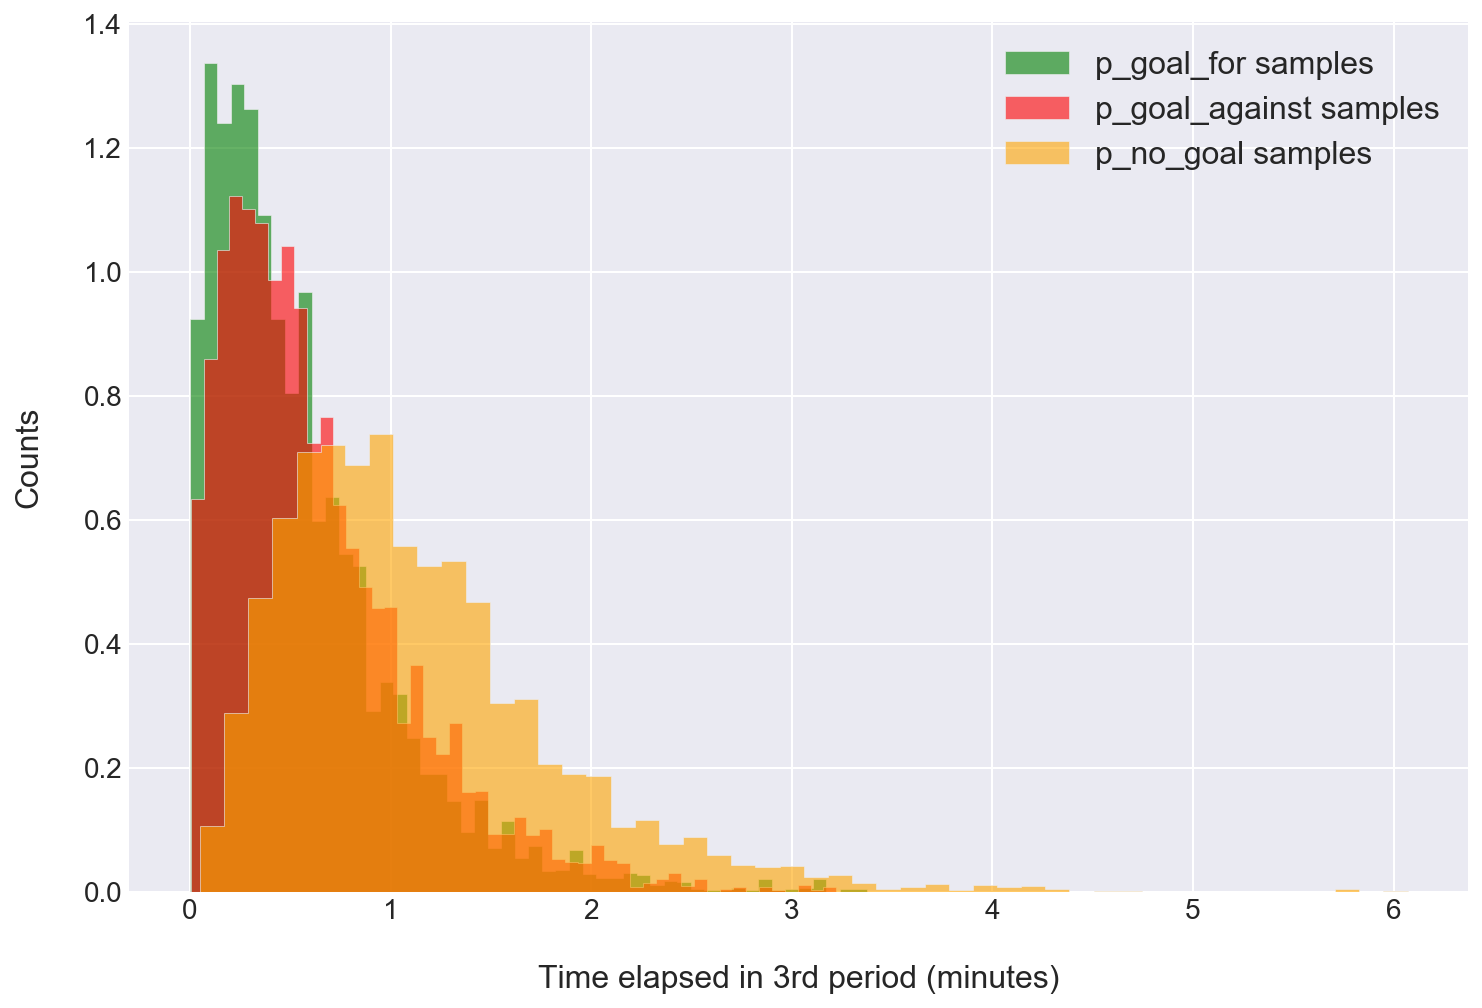

In [194]:
ALPHA = 0.6
LW = 3

''' Plot MCMC samples '''

plt.hist(burned_trace['p_goal_for']/60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against']/60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_no_goal']/60, bins=50,
         color='orange', label='p_no_goal samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Clean up the chart '''

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.legend()

# savefig(plt, 'time_elapsed_gamma_mcmc_samples')

plt.show()

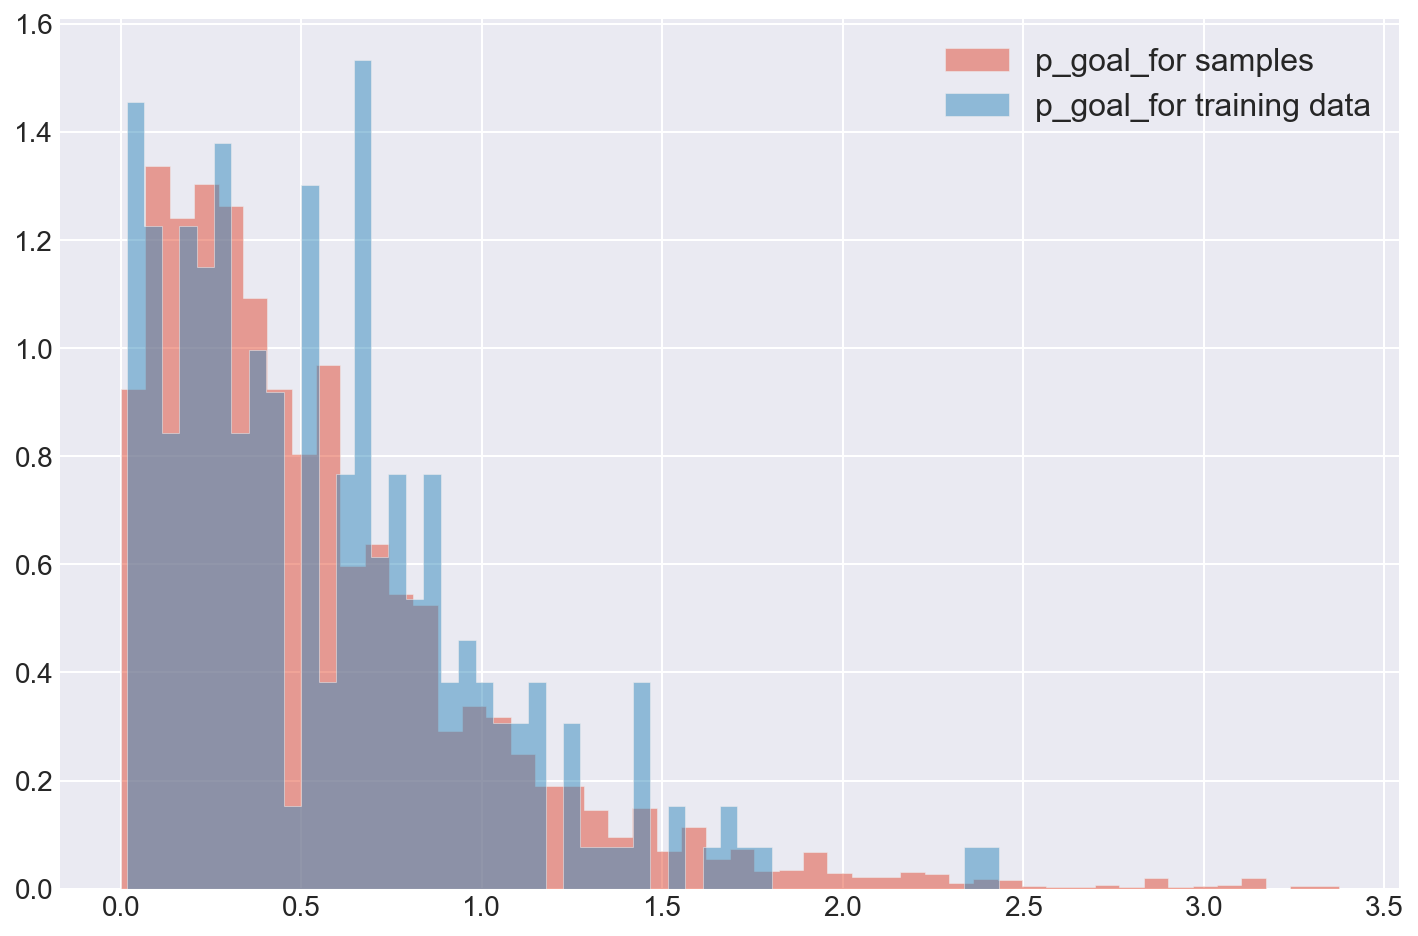

In [195]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_goal_for']/60, bins=50,
         label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[0]/60, bins=50,
         label='p_goal_for training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

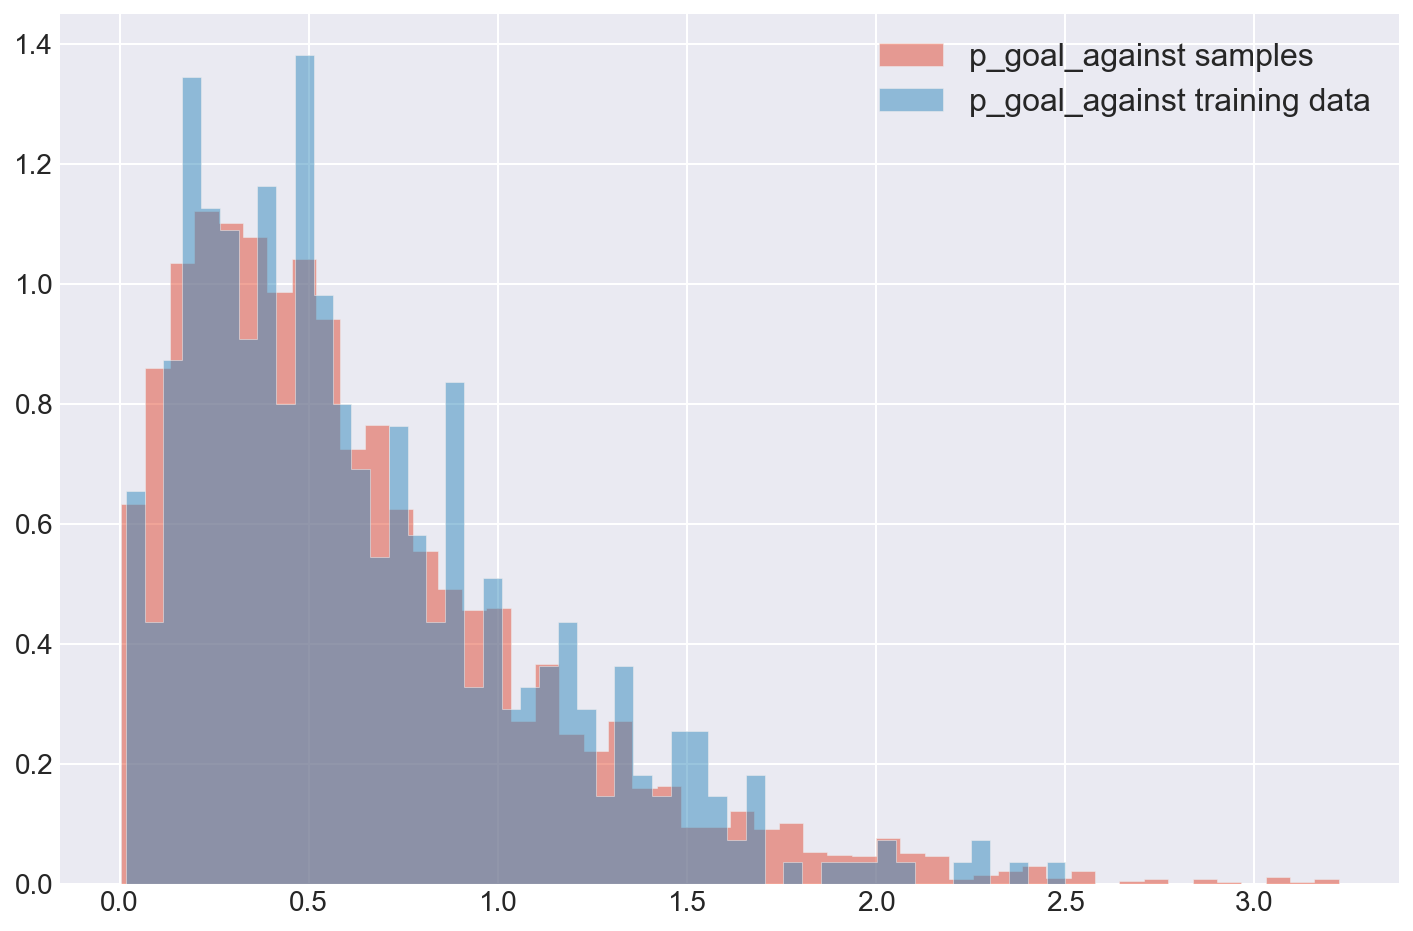

In [196]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_goal_against']/60, bins=50,
         label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[1]/60, bins=50,
         label='p_goal_against training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

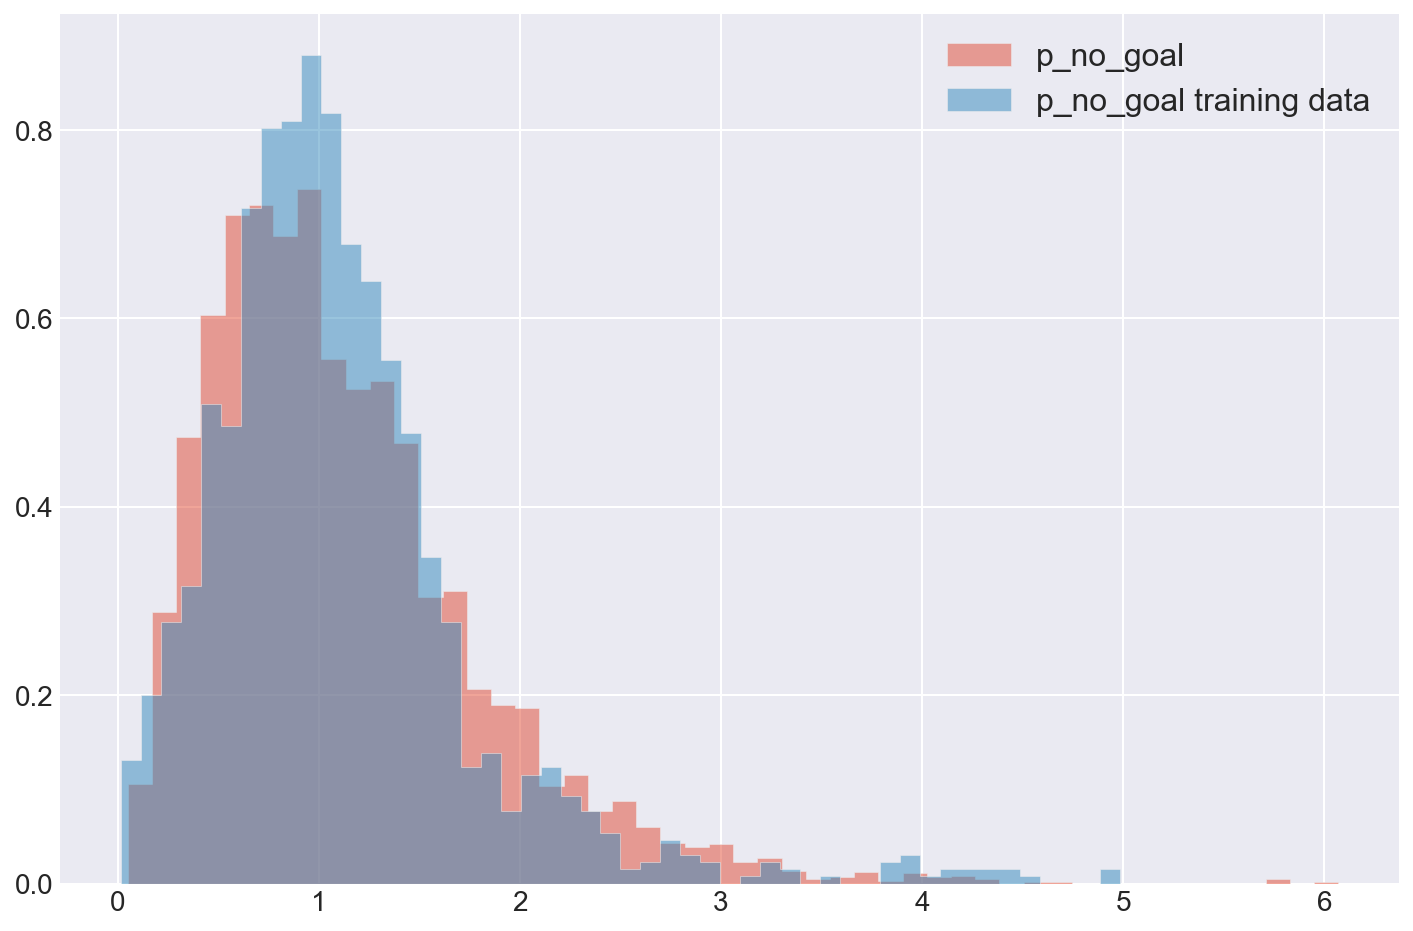

In [197]:
ALPHA = 0.5

''' Plot MCMC samples & training data '''

plt.hist(burned_trace['p_no_goal']/60, bins=50,
         label='p_no_goal',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(training_samples[2]/60, bins=50,
         label='p_no_goal training data',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.legend()
plt.show()

In [72]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')